## Setting Up the Environment

First, let's import the necessary libraries and configure the environment.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import mne
import yaml
from pathlib import Path
import logging
import importlib

# Add the parent directory to path to import custom modules
sys.path.append(os.path.abspath('../..'))

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('fivepoint_pipeline')

# MNE settings
mne.set_log_level('INFO')
%matplotlib inline

## Loading the Pipeline Configuration

We'll load the minimal pipeline configuration from the YAML file.

In [2]:
# Load the minimal pipeline configuration
config_path = '../../configs/fivepoint_pipeline.yml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)
print(f"Loaded configuration from {config_path}")

print("Pipeline steps:")
for step in config['pipeline']['steps']:
    print(f"- {step['name']}")

# Extract key configuration parameters
root_dir = config['directory']['root']
raw_data_dir = os.path.join(root_dir, config['directory']['raw_data_dir'])
processed_dir = os.path.join(root_dir, config['directory']['processed_dir'])
file_pattern = config['file_path_pattern']

# Ensure directories exist
os.makedirs(processed_dir, exist_ok=True)

Loaded configuration from ../../configs/fivepoint_pipeline.yml
Pipeline steps:
- LoadData
- PrepChannelsStep
- FilterStep
- EpochingStep
- SaveCheckpoint


## Step 1: Loading the Data

The first step is to load the raw EEG data. For Go/No-Go tasks, we expect the data to be in FIFF format.

In [3]:
# Step 1: Loading the Data
# Extract loading parameters from the configuration
load_data_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'LoadData')

# Construct the file path
file_path = os.path.join(raw_data_dir, file_pattern)

# Import and use the LoadData class from the pipeline
from scr.steps.load import LoadData

# Create and apply the load data step
logger.info(f"Loading data using LoadData")
load_data_step = LoadData(params=load_data_config.get('params', {}))

# For LoadData step, we pass the file path in the params
load_params = load_data_step.params.copy()
load_params["input_file"] = file_path
load_data_step.params = load_params

raw = load_data_step.run(None)

# Display basic information about the raw data
print("\nRaw data information:")
print(f"Number of channels: {len(raw.ch_names)}")
print(f"Sampling frequency: {raw.info['sfreq']} Hz")
print(f"Duration: {raw.times[-1]:.2f} seconds")

%matplotlib TkAgg

# Plot the raw data (first 10 seconds)
# raw.plot(duration=10, n_channels=20, title='Raw EEG data')

2025-04-20 12:39:55,267 - root - WARNING - [ICAExtractionStep] PyQt5 not found, defaulting to Agg backend
2025-04-20 12:39:55,449 - numexpr.utils - INFO - NumExpr defaulting to 12 threads.
2025-04-20 12:39:55,818 - root - INFO - [__init__.py] All step classes have been registered in STEP_REGISTRY.
2025-04-20 12:39:55,819 - fivepoint_pipeline - INFO - Loading data using LoadData


Extracting EDF parameters from d:\Yann\neurotheque_resources\data\pilot_data\sub-01_ses-001_task-5pt_run-01_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 96599  =      0.000 ...   321.997 secs...

Raw data information:
Number of channels: 27
Sampling frequency: 300.0 Hz
Duration: 322.00 seconds


Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


## Step 2: Channel Preparation

The `PrepChannelsStep` handles channel renaming, type setting, and montage application.

In [4]:
# Step 2: Channel Preparation
# Extract parameters from the configuration
prep_channels_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'PrepChannelsStep')

# Set the referencing parameters
if 'params' not in prep_channels_config:
    prep_channels_config['params'] = {}
    
prep_channels_config['params']['reference'] = {
    'method': 'average',  # Change from Pz (channels) to average reference
    'projection': False
}

# Force reload the module to ensure we have the latest version
import scr.steps.prepchannels
importlib.reload(scr.steps.prepchannels)

# Use the PrepChannelsStep with referencing
from scr.steps.prepchannels import PrepChannelsStep

# Create and apply the channel preparation step
logger.info(f"Preparing channels with referencing")
prep_channels_step = PrepChannelsStep(params=prep_channels_config['params'])
raw = prep_channels_step.run(raw)

# Print channel names after prep to verify ECG channel was dropped
print("\nChannel names after preparation:")
print(raw.ch_names)

2025-04-20 12:39:57,883 - fivepoint_pipeline - INFO - Preparing channels with referencing
2025-04-20 12:39:57,884 - root - INFO - [PrepChannelsStep] Running with params: {'on_missing': 'ignore', 'reference': {'method': 'average', 'projection': False}}
2025-04-20 12:39:57,892 - root - INFO - Dropped non-EEG: ['EEG X1:-Pz', 'EEG X2:-Pz', 'EEG X3:-Pz', 'CM', 'EEG A1-Pz', 'EEG A2-Pz', 'Event']
2025-04-20 12:39:57,893 - root - INFO - Renamed 18 EEG channels
d:\Yann\neurotheque_resources\scr\steps\prepchannels.py:53: RuntimeWarning: The unit for channel(s) Trigger has changed from NA to V.
  data.set_channel_types({ch: 'stim'})
2025-04-20 12:39:57,896 - root - INFO - Channel types set: 19 EEG, 1 STIM, 0 MISC
2025-04-20 12:39:57,896 - root - INFO - [PrepChannelsStep] Applying re-referencing with params: {'method': 'average', 'projection': False}
2025-04-20 12:39:57,897 - root - INFO - [apply_reference] Re-referencing method=average, projection=False
2025-04-20 12:39:57,897 - root - INFO - [ap

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


2025-04-20 12:39:57,912 - root - INFO - [apply_reference] Re-reference complete.
2025-04-20 12:39:57,913 - root - INFO - [PrepChannelsStep] Re-referencing applied successfully
2025-04-20 12:39:57,938 - root - INFO - [PrepChannelsStep] Standard 10-20 montage applied
2025-04-20 12:39:57,939 - root - INFO - [PrepChannelsStep] Channels prepared successfully.



Channel names after preparation:
['P3', 'C3', 'F3', 'Fz', 'F4', 'C4', 'P4', 'Cz', 'Fp1', 'Fp2', 'T3', 'T5', 'O1', 'O2', 'F7', 'F8', 'T6', 'T4', 'Pz', 'Trigger']


## Step 3: Filtering

Filtering is a crucial step to remove unwanted frequency components from the signal. We apply:
1. A bandpass filter to remove slow drifts and high-frequency noise
2. Notch filters to remove power line interference

2025-04-20 12:40:00,019 - fivepoint_pipeline - INFO - Applying filtering using FilterStep


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 991 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1981 samples (6.603 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Effective window size : 6.827 (s)
Plotting power spectral density (dB=True).
Using matplotlib as 2D backend.


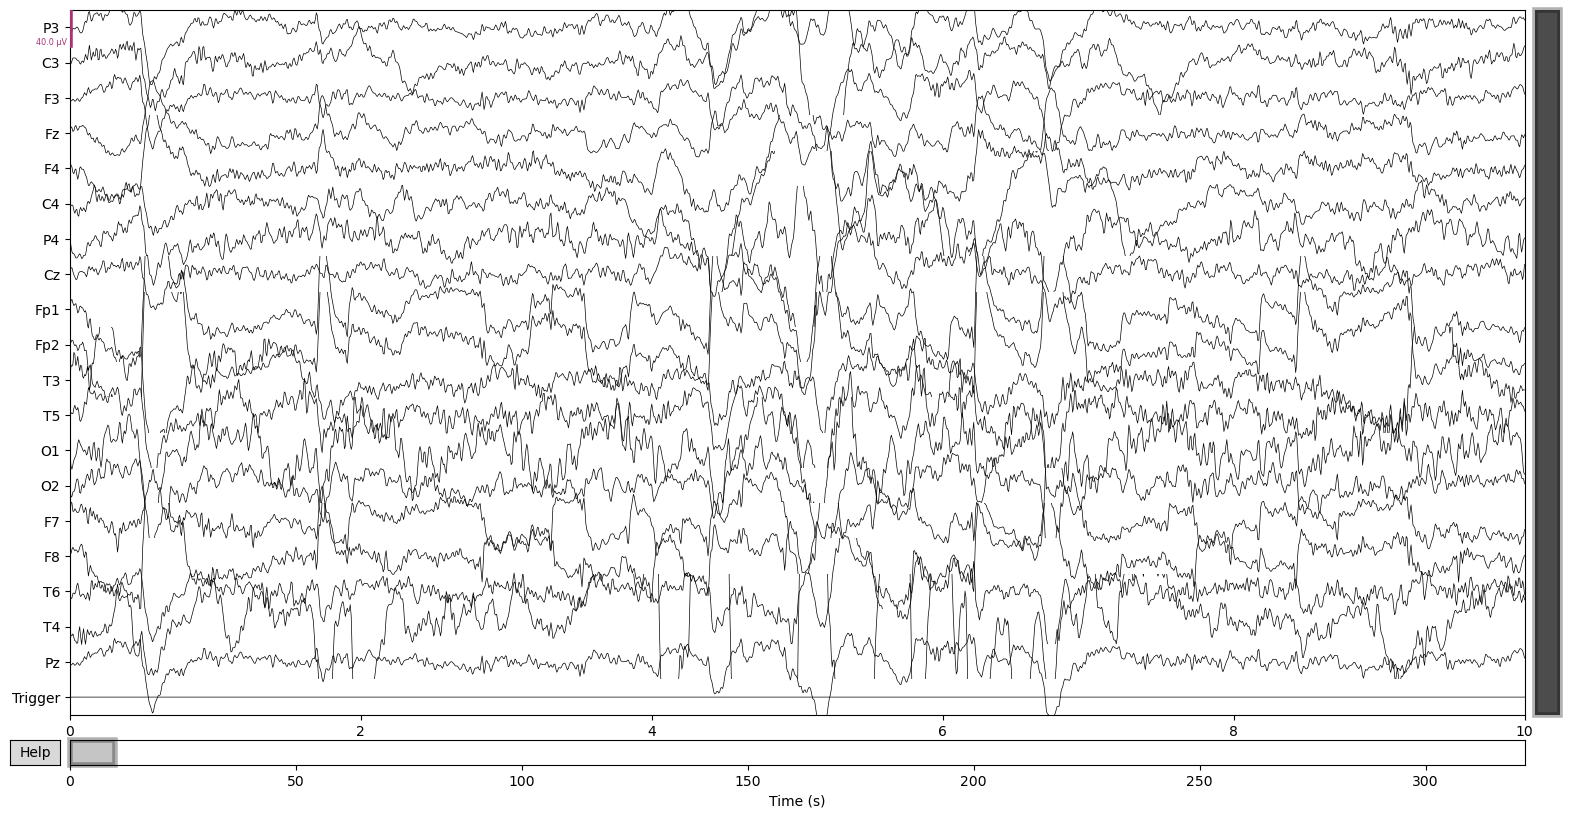

In [5]:
# Step 3: Filtering
# Extract filtering parameters from the configuration
filter_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'FilterStep')

# Use the FilterStep from the pipeline
from scr.steps.filter import FilterStep

# Create and apply the filter step
logger.info(f"Applying filtering using FilterStep")
filter_step = FilterStep(params=filter_config['params'])
raw = filter_step.run(raw)

# Plot power spectral density after filtering
fig, ax = plt.subplots(figsize=(10, 6))
raw.compute_psd(fmax=filter_config['params']['h_freq']*1.5, picks='eeg').plot(show=True)
ax.set_title('Power Spectral Density after Filtering')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (dB)')
plt.show()

# Plot filtered data
raw.plot(duration=10, n_channels=20, title='Filtered EEG data')

## Advanced Spectral Analysis

Let's use the spectral analysis utilities to visualize the data in different ways.

In [ ]:
# Example of using the spectral analysis utilities
from scr.utils.spectral import compute_and_plot_psd

# Plot standard PSD
logger.info("Plotting standard PSD")
try:
    compute_and_plot_psd(raw, 
                        fmin=0.5, 
                        fmax=filter_config['params']['h_freq']*1.5,
                        picks='eeg',
                        plot_type='standard')
except Exception as e:
    logger.error(f"Error plotting standard PSD: {str(e)}")

# Plot average PSD across channels
logger.info("Plotting average PSD")
try:
    compute_and_plot_psd(raw, 
                        fmin=0.5, 
                        fmax=filter_config['params']['h_freq']*1.5,
                        picks='eeg',
                        plot_type='average',
                        plot_kwargs={'color': 'blue', 'linewidth': 2})
except Exception as e:
    logger.error(f"Error plotting average PSD: {str(e)}")

# Plot PSD by frequency bands
logger.info("Plotting PSD by frequency bands")
try:
    compute_and_plot_psd(raw, 
                        fmin=0.5, 
                        fmax=45,
                        picks='eeg',
                        plot_type='bands',
                        plot_kwargs={'bands': {
                            'delta': (1, 4),
                            'theta': (4, 8),
                            'alpha': (8, 13),
                            'beta': (13, 30),
                            'gamma': (30, 45)
                        }})
except Exception as e:
    logger.error(f"Error plotting PSD by frequency bands: {str(e)}")

## Step 4: Epoching for Autoreject

For the five-point test, we'll create fixed-length epochs of 2 seconds duration without any baseline correction. This approach creates uniform time segments that are ideal for the autoreject algorithm, which can then identify and handle artifacts in a consistent way across the entire recording.

Instead of event-locked epochs, we're creating regular fixed-length segments (2 seconds each) throughout the recording. This method:
- Provides consistent coverage of the entire recording
- Creates uniform segments for artifact detection
- Works well when specific event markers aren't needed for analysis
- Is particularly effective for autoreject processing

In [9]:
# Step 4: Epoching
# Extract epoching parameters from the configuration
epoch_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'EpochingStep')

# Make sure required parameters are set
if 'params' not in epoch_config:
    epoch_config['params'] = {}

# Set critical parameters for fixed-length epochs for five-point task
epoch_config['params']['task_type'] = 'fixed'  # Use fixed-length epochs
epoch_config['params']['stim_channel'] = 'Trigger'  # Make sure stim channel is set

# Configure fixed-length epoch parameters
epoch_config['params']['epoch_params'] = {
    'duration': 4.0,      # 2-second epochs
    'overlap': 0.0,       # No overlap between segments
    'baseline': None,     # No baseline correction
    'preload': True,
    'reject_by_annotation': True
}

# Configure the event visualization
epoch_config['params']['visualize_events'] = True
epoch_config['params']['plot_params'] = {
    # Event visualization parameters
    'duration': 15.0,
    'tstart': 0.0,
    'interactive': True,
    'save_plots': True,
    'save_dir': os.path.join(processed_dir, 'figures/events')
}

# Log important parameters for reference
duration = epoch_config['params']['epoch_params']['duration']
overlap = epoch_config['params']['epoch_params']['overlap']
baseline = epoch_config['params']['epoch_params']['baseline']
stim_channel = epoch_config['params']['stim_channel']

print("\nFixed-length epoch parameters:")
print(f"- Duration: {duration}s")
print(f"- Overlap: {overlap}s")
print(f"- Baseline: {baseline}")

# Create and run the epoching step
from scr.steps.epoching import EpochingStep
logger.info(f"Creating fixed-length epochs of {duration}s duration with task_type={epoch_config['params']['task_type']}")
epoch_step = EpochingStep(params=epoch_config['params'])

# Run the epoching step
try:
    epochs = epoch_step.run(raw)

    # Display information about the epochs
    print("\nEpochs information:")
    print(epochs)

    # Use the generate_plots method with butterfly plot type (should work well)
    try:
        butterfly_plot = epoch_step.generate_plots(
            epochs,
            plot_params={
                'plot_type': 'butterfly',
                'event_names': ['fixed'],
                'channels': ['Fz', 'Cz', 'Pz'],
                'time_window': [0, 2.0],
                'save_plots': True,
                'save_dir': os.path.join(processed_dir, 'figures/epochs')
            }
        )
        print("Successfully generated butterfly plot")
    except Exception as e:
        print(f"Error generating butterfly plot: {str(e)}")
    
    # Try the average plot type with minimal parameters
    try:
        average_plot = epoch_step.generate_plots(
            epochs,
            plot_params={
                'plot_type': 'average',
                'event_names': ['fixed'],
                'channels': ['Fz', 'Cz', 'Pz'],
                # Avoid passing title which may cause issues
                'save_plots': True,
                'save_dir': os.path.join(processed_dir, 'figures/epochs')
            }
        )
        print("Successfully generated average plot")
    except Exception as e:
        print(f"Error generating average plot: {str(e)}")
    
    # Use direct MNE plotting methods as a fallback
    print("\nUsing MNE's native plotting methods...")
    
    # Plot a few channels from a few epochs
    fig1 = epochs.plot(picks=['Fz', 'Cz', 'Pz'], n_epochs=5, 
                      scalings='auto', 
                      title='Fixed-length 2s epochs')
    
    # Plot the average across all fixed epochs
    evoked = epochs.average()
    fig2 = evoked.plot(picks=['Fz', 'Cz', 'Pz'], 
                      titles='Average of fixed-length epochs')
    
    # Use the newer PSD method to avoid deprecation warnings
    fig3 = epochs.compute_psd().plot(picks=['Fz', 'Cz', 'Pz'], 
                                   average=True)
    
    # Save the figures
    save_dir = os.path.join(processed_dir, 'figures/epochs')
    os.makedirs(save_dir, exist_ok=True)
    
    fig1.savefig(os.path.join(save_dir, 'fixed_epochs_raw.png'))
    fig2.savefig(os.path.join(save_dir, 'fixed_epochs_average.png'))
    fig3.savefig(os.path.join(save_dir, 'fixed_epochs_psd.png'))
    
except Exception as e:
    logger.error(f"Error in epoching step: {str(e)}")

2025-04-20 12:42:11,540 - fivepoint_pipeline - INFO - Creating fixed-length epochs of 4.0s duration with task_type=fixed
2025-04-20 12:42:11,541 - root - INFO - [EpochingStep.__init__] Initialized with params: {'task_type': 'fixed', 'trigger_ids': {'go': 1, 'nogo': 2, 'response': 3}, 'epoch_params': {'duration': 4.0, 'overlap': 0.0, 'baseline': None, 'preload': True, 'reject_by_annotation': True}, 'stim_channel': 'Trigger', 'returns_epochs': True, 'visualize_events': True, 'plot_params': {'duration': 15.0, 'tstart': 0.0, 'interactive': True, 'save_plots': True, 'save_dir': 'd:/Yann/neurotheque_resources/data/processed\\figures/events'}}
2025-04-20 12:42:11,542 - root - INFO - [EpochingStep.run] Running with params: {'task_type': 'fixed', 'trigger_ids': {'go': 1, 'nogo': 2, 'response': 3}, 'epoch_params': {'duration': 4.0, 'overlap': 0.0, 'baseline': None, 'preload': True, 'reject_by_annotation': True}, 'stim_channel': 'Trigger', 'returns_epochs': True, 'visualize_events': True, 'plot_p


Fixed-length epoch parameters:
- Duration: 4.0s
- Overlap: 0.0s
- Baseline: None
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 80 events and 1201 original time points ...
0 bad epochs dropped


2025-04-20 12:42:11,571 - root - INFO - [EpochingStep] Created 80 fixed-length epochs


Adding metadata with 0 columns

Epochs information:
<Epochs | 80 events (all good), 0 – 4 s (baseline off), ~14.7 MiB, data loaded, with metadata,
 'fixed': 80>


d:\Yann\neurotheque_resources\scr\steps\epoching.py:995: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
2025-04-20 12:42:12,189 - root - INFO - [EpochingStep] Saved figure to d:\Yann\neurotheque_resources\data\processed\figures\epochs\sub-unknown_ses-001_plot-1.png


Successfully generated butterfly plot


d:\Yann\neurotheque_resources\scr\steps\epoching.py:977: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
d:\Yann\neurotheque_resources\scr\steps\epoching.py:977: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
2025-04-20 12:42:12,820 - root - INFO - [EpochingStep] Saved figure to d:\Yann\neurotheque_resources\data\processed\figures\epochs\sub-unknown_ses-001_plot-1.png


Successfully generated average plot

Using MNE's native plotting methods...
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


In [ ]:
# Define output file path and save epochs

# Get save checkpoint step configuration from pipeline config
save_checkpoint_config = next(step for step in config['pipeline']['steps'] if step['name'] == 'SaveCheckpoint')

# Import the SaveCheckpoint class from the pipeline steps
from scr.steps.save_checkpoint import SaveCheckpoint

# Create paths object from config if not already available
from scr.steps.project_paths import ProjectPaths
paths = ProjectPaths(config)

# Prepare parameters for SaveCheckpoint
save_params = save_checkpoint_config.get('params', {}).copy()

# Add required parameters
save_params.update({
    "subject_id": config.get('default_subject', '01'),
    "session_id": config.get('default_session', '001'),
    "task_id": "gng",
    "run_id": config.get('default_run', '01'),
    "checkpoint_key": "epoched",  # Customize the checkpoint name
    "paths": paths,
    "overwrite": True
})

# Create and run the SaveCheckpoint step
save_step = SaveCheckpoint(params=save_params)
save_step.run(epochs)

# Get the path for informational message
checkpoint_path = paths.get_checkpoint_path(
    subject_id=save_params["subject_id"],
    session_id=save_params["session_id"],
    task_id=save_params["task_id"],
    run_id=save_params["run_id"],
    checkpoint_name=save_params["checkpoint_key"]
)

print(f"\nPreprocessed epochs saved as checkpoint: {checkpoint_path}")



# Step 5: First AutoReject Pass
We now apply AutoReject to identify bad epochs from our fixed-length segments. AutoReject uses a machine learning approach to automatically detect and reject or repair problematic epochs, ensuring high data quality without subjective manual rejection.

In [10]:
# Step 5: Apply AutoReject to identify bad epochs
from scr.steps.autoreject import AutoRejectStep

# Configure AutoReject parameters
ar_params_dict = {
    "n_interpolate": None,  # Use default values
    "consensus": None,      # Use default values
    "thresh_method": "bayesian_optimization",
    "n_jobs": 1,
}

# Set up the AutoReject step parameters
autoreject_dir = os.path.join(processed_dir, "autoreject")
os.makedirs(autoreject_dir, exist_ok=True)

autoreject_params = {
    "ar_params": ar_params_dict,
    "plot_results": True,  
    "interactive": True,   
    "mode": "fit",                  # Only identify bad epochs, don't clean yet
    "file_prefix": "ar_first_pass",
    "output_dir": os.path.join(processed_dir, "autoreject"),
    "plot_dir": autoreject_dir,     
    "store_reject_log": True,
    "save_model": False,            
    "subject_id": config.get('default_subject', '01'),
    "session_id": config.get('default_session', '001'),
    "run_id": config.get('default_run', '01'),
    "save_cleaned_data": False,     
}

# Create and run the AutoReject step
logger.info("Applying AutoReject to identify bad epochs")
autoreject_step = AutoRejectStep(params=autoreject_params)
print(f"Data shape before AutoReject: {epochs.get_data().shape} (epochs x channels x time points)")
epochs_with_ar = autoreject_step.run(epochs)

# Display results
if hasattr(epochs_with_ar, 'metadata') and 'ar_reject_log' in epochs_with_ar.metadata:
    reject_log = epochs_with_ar.metadata['ar_reject_log']
    n_bad_epochs = reject_log.bad_epochs.sum()
    percent_bad = (n_bad_epochs / len(epochs)) * 100
    print(f"\nAutoReject identified {n_bad_epochs} bad epochs ({percent_bad:.1f}% of total)")

2025-04-20 12:42:27,099 - fivepoint_pipeline - INFO - Applying AutoReject to identify bad epochs
2025-04-20 12:42:27,105 - root - INFO - [AutoRejectStep] Data type: <class 'mne.epochs.Epochs'>
2025-04-20 12:42:27,106 - root - INFO - [AutoRejectStep] Is instance of mne.Epochs: True
2025-04-20 12:42:27,106 - root - INFO - [AutoRejectStep] Switching matplotlib backend from tkagg to TkAgg for interactive plotting
2025-04-20 12:42:27,108 - root - INFO - [AutoRejectStep] Using existing epochs for AutoReject.
2025-04-20 12:42:27,108 - root - INFO - [AutoRejectStep] Running AutoReject with params: {'n_interpolate': None, 'consensus': None, 'thresh_method': 'bayesian_optimization', 'n_jobs': 1}


Data shape before AutoReject: (80, 20, 1201) (epochs x channels x time points)
Running autoreject on ch_type=eeg


100%|██████████| Creating augmented epochs : 19/19 [00:00<00:00,   58.62it/s]
100%|██████████| Computing thresholds ... : 19/19 [00:17<00:00,    1.08it/s]









































100%|██████████| Repairing epochs : 80/80 [00:00<00:00,  113.04it/s]





























































100%|██████████| Repairing epochs : 80/80 [00:01<00:00,   65.59it/s]






















100%|██████████| Fold : 10/10 [00:02<00:00,    4.15it/s]




























































100%|██████████| Repairing epochs : 80/80 [00:01<00:00,   64.43it/s]






















100%|██████████| Fold : 10/10 [00:01<00:00,    5.05it/s]
























c:\Users\s\anaconda3\envs\eeg_env\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\s\anaconda3\envs\eeg_env\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.ty





Estimated consensus=0.50 and n_interpolate=4


2025-04-20 12:42:55,702 - root - WARNING - [AutoRejectStep] Error creating thresholds visualization: 0
2025-04-20 12:42:55,703 - root - INFO - [AutoRejectStep] Excluding trigger/stim channels from rejection plot: ['Trigger']
2025-04-20 12:42:56,160 - root - INFO - [AutoRejectStep] Saved channel rejection rates visualization to d:/Yann/neurotheque_resources/data/processed\autoreject
2025-04-20 12:42:56,161 - root - INFO - [AutoRejectStep] Stored AutoReject information in data.info['temp']
2025-04-20 12:42:56,161 - root - INFO - [AutoRejectStep] Bad epochs: 9 out of 80
2025-04-20 12:42:56,162 - root - INFO - [AutoRejectStep] VERIFICATION: Found 9 bad epochs in info['temp']
2025-04-20 12:42:56,162 - root - INFO - [AutoRejectStep] Switching matplotlib backend back to tkagg


## Step 6: ICA Extraction

Now we'll run Independent Component Analysis (ICA) on the good epochs identified by AutoReject.

2025-04-20 12:43:13,654 - fivepoint_pipeline - INFO - Running ICA extraction for task: 5pt
2025-04-20 12:43:13,746 - root - INFO - [ICAExtractionStep] Jupyter environment detected, using inline backend
2025-04-20 12:43:13,746 - root - INFO - [ICAExtractionStep] Using data with AutoReject annotations to exclude bad segments.
2025-04-20 12:43:13,747 - root - INFO - [ICAExtractionStep] Input is already epoched data
2025-04-20 12:43:13,747 - root - INFO - [ICAExtractionStep] Found 9 bad epochs from autoreject_bad_epochs
2025-04-20 12:43:13,759 - root - INFO - [ICAExtractionStep] Using 71/80 good epochs for ICA
2025-04-20 12:43:13,761 - root - INFO - [ICAExtractionStep] Saving plots to d:/Yann/neurotheque_resources/data/processed\ica
2025-04-20 12:43:13,761 - root - INFO - [ICAExtractionStep] Fitting ICA with 18 components using infomax method...


Data shape before ICA extraction: (80, 20, 1201)
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 18 components
Computing Extended Infomax ICA
Fitting ICA took 13.0s.


2025-04-20 12:43:26,742 - root - INFO - [ICAExtractionStep] ICA fitted successfully. Found 18 components.
2025-04-20 12:43:26,743 - root - INFO - [ICAExtractionStep] Generating component topography plots


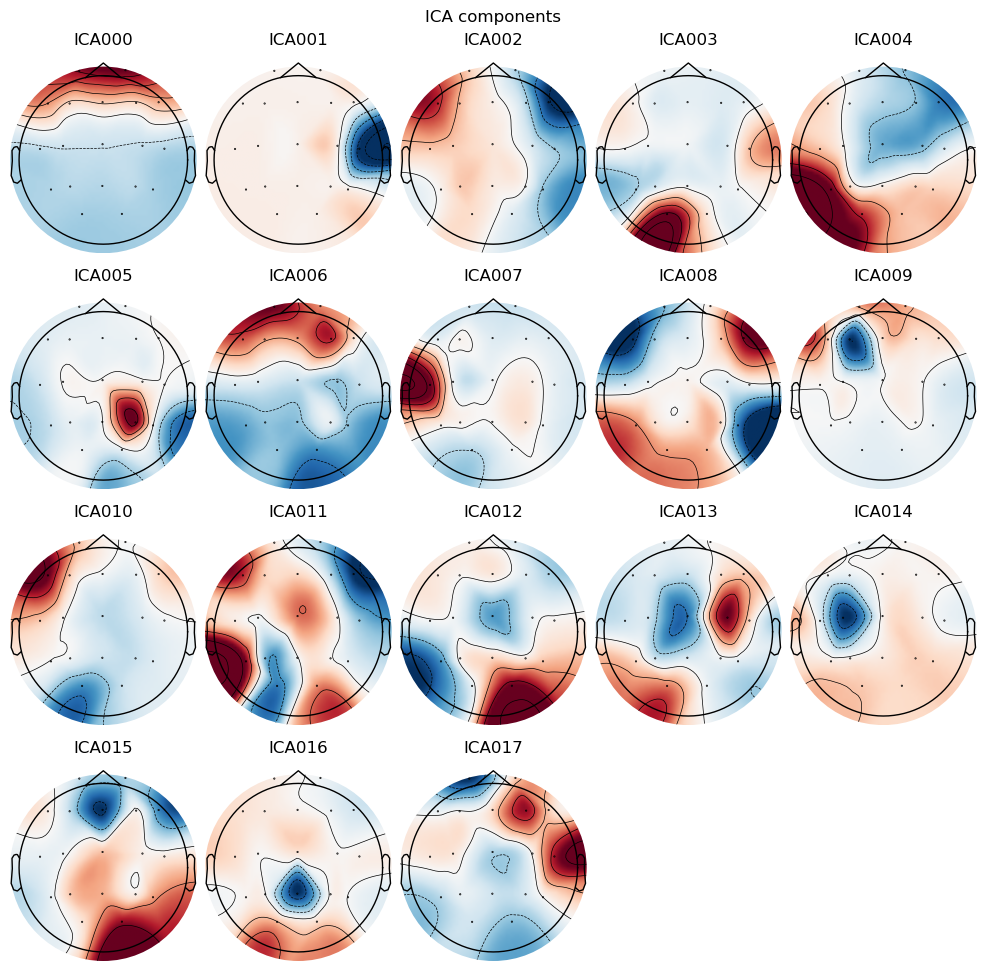


Displaying 1 generated ICA figures...

ICA extraction complete.


In [11]:
# Step 6: Run ICA extraction on the AutoReject results
from scr.steps.ica_extraction import ICAExtractionStep
import matplotlib.pyplot as plt

# Ensure plots are displayed inline in the notebook
%matplotlib inline

# Define directory for ICA plots
ica_extraction_dir = os.path.join(processed_dir, "ica")
os.makedirs(ica_extraction_dir, exist_ok=True)

# Configure ICA parameters
ica_params = {
    "n_components": 18,  # Adjust based on number of channels and desired variance explained
    "method": "infomax",   # Suitable for EEG
    "max_iter": 2000,      # Increase iterations for potentially better convergence
    "fit_params": {"extended": True},  # Extended Infomax for diverse source types
    "decim": None             # No temporal decimation
}

# Retrieve subject/session/run/task IDs (ensure these are defined earlier)
sub_id = config.get('default_subject', '01')
ses_id = config.get('default_session', '001')
run_id = config.get('default_run', '01')
task_id = '5pt' # Set task ID specifically for the five-point task

# Set up the ICA extraction step parameters
ica_extraction_params = {
    "n_components": ica_params["n_components"],
    "method": ica_params["method"],
    "max_iter": ica_params["max_iter"],
    "fit_params": ica_params["fit_params"],
    "decim": ica_params["decim"],
    "use_good_epochs_only": True,  # Use only good epochs identified by AutoReject
    "plot_dir": ica_extraction_dir,
    "plot_components": True,       # Plot the component topographies
    "plot_sources": False,          # Plot the time course of components
    "plot_properties": False,       # Plot detailed properties (spectrum, variance, etc.)
    "plot_psd": False,              # Plot PSD of components
    "interactive": False,          # Set to False for notebook display
    "subject_id": sub_id,
    "session_id": ses_id,
    "run_id": run_id,
    "task_id": task_id,            # Use the correct task ID
    "save_data": False,            # Don't save checkpoint here
    "store_ica_in_epochs": True   # Store ICA object in epochs.info['temp']                # Pass the ProjectPaths object
}

# Create and run the ICA extraction step
logger.info(f"Running ICA extraction for task: {task_id}")
ica_extraction_step = ICAExtractionStep(params=ica_extraction_params)

# Ensure the input is the epochs object from the previous AutoReject step
if 'epochs_with_ar' in locals() and epochs_with_ar is not None:
    print(f"Data shape before ICA extraction: {epochs_with_ar.get_data().shape}")
    try:
        # The run method will use the 'autoreject_bad_epochs' stored in info['temp']
        epochs_with_ica = ica_extraction_step.run(epochs_with_ar)
        
        # Display ICA figures manually since interactive=False
        if hasattr(ica_extraction_step, 'figures') and ica_extraction_step.figures:
            print(f"\nDisplaying {len(ica_extraction_step.figures)} generated ICA figures...")
            for fig in ica_extraction_step.figures:
                # Check if the figure still exists (might have been closed)
                if plt.fignum_exists(fig.number):
                    plt.figure(fig.number) # Bring figure to front
                    plt.show() # Display the figure
        
        print("\nICA extraction complete.")
        
    except Exception as e:
        logger.error(f"Error during ICA extraction: {str(e)}")
else:
    logger.error("Input epochs object 'epochs_with_ar' not found or is None.")


## Step 7: ICA Labeling and Artifact Removal

In this step, we'll identify and remove ICA components related to artifacts (eye movements, muscle activity, heartbeat).

Saving exclusion plots to: d:/Yann/neurotheque_resources/data/processed\ica_exclusion_plots

--- Running ICLabel Classification ---


C:\Users\s\AppData\Local\Temp\ipykernel_35264\1898270091.py:30: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(epochs_for_cleaning, ica, method='iclabel')


ICLabel classifications:
IC0: eye blink (97.6%)
IC1: other (50.9%)
IC2: eye blink (95.4%)
IC3: other (52.2%)
IC4: brain (80.0%)
IC5: brain (78.5%)
IC6: brain (52.8%)
IC7: other (66.4%)
IC8: other (48.5%)
IC9: other (47.4%)
IC10: brain (69.6%)
IC11: other (70.1%)
IC12: brain (60.1%)
IC13: brain (64.7%)
IC14: brain (94.6%)
IC15: other (90.9%)
IC16: brain (86.6%)
IC17: other (82.2%)

Components to exclude: [0, 2]
Exclusion by artifact type:
  eye blink: [0, 2]
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated


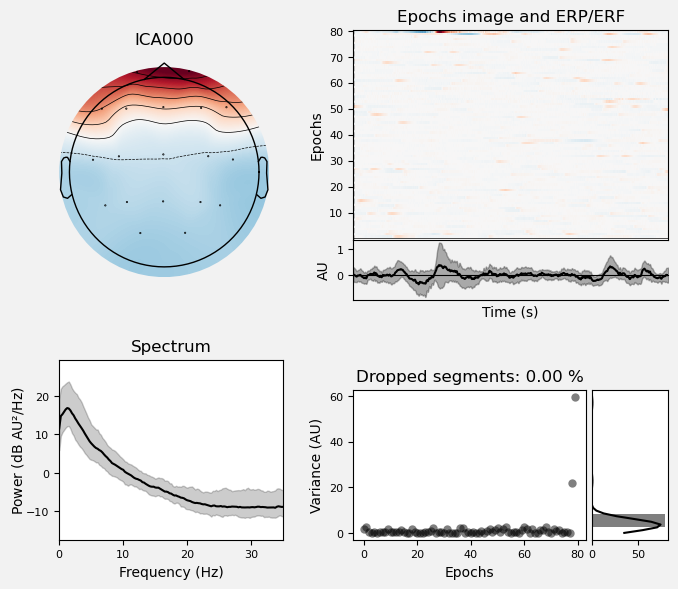

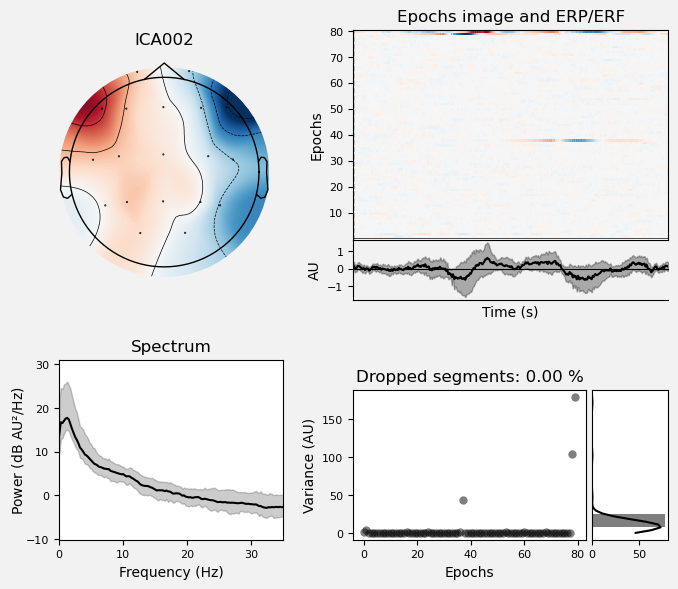

Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components

--- Applying ICA exclusion to create clean dataset ---
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Error during I

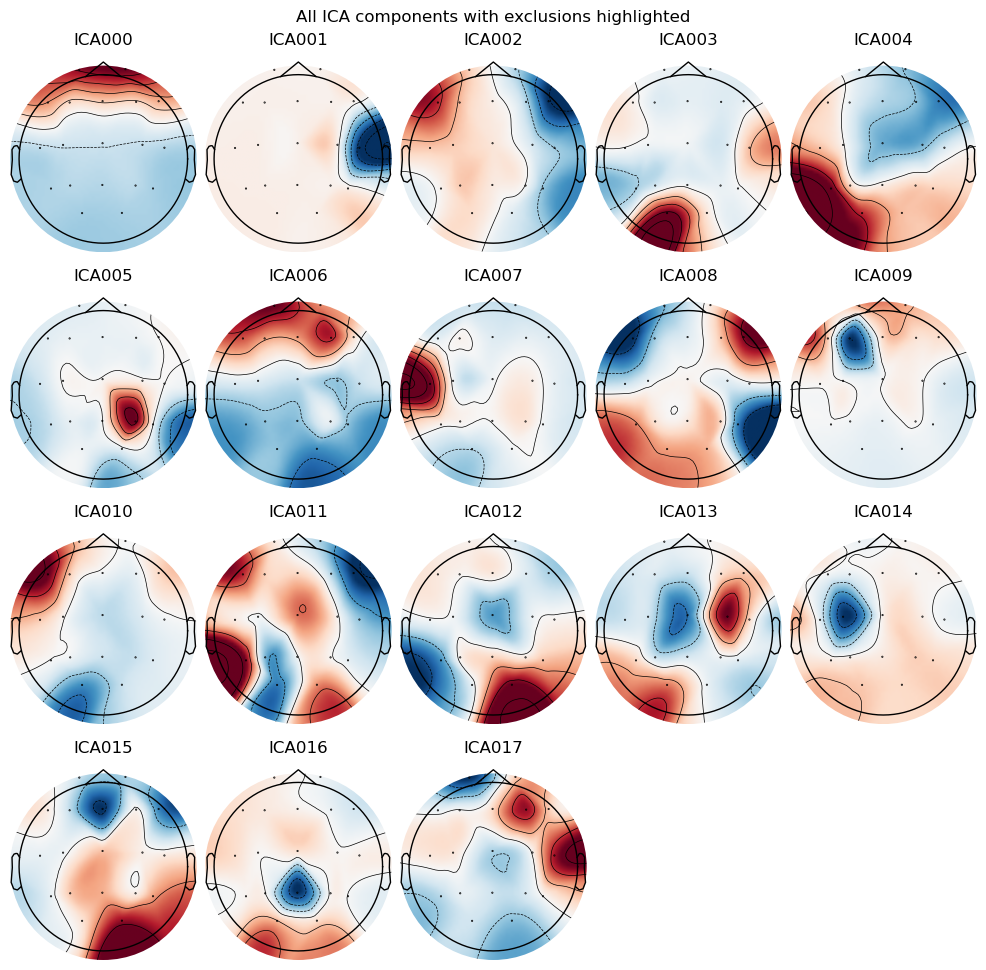


Additional plots created to clearly show excluded components


In [12]:
# Step 8: Using ICLabel to identify and exclude artifact components

import mne
import matplotlib.pyplot as plt
import numpy as np
import os
from mne.preprocessing import ICA
from mne_icalabel import label_components

# Ensure plots are displayed inline
%matplotlib inline



# Get the ICA solution
ica = epochs_with_ica.info['temp']['ica']
epochs_for_cleaning = epochs_with_ica.copy()  # Work on a copy

# --- Plotting Directory ---
ica_clean_dir = os.path.join(processed_dir, "ica_exclusion_plots")
os.makedirs(ica_clean_dir, exist_ok=True)
print(f"Saving exclusion plots to: {ica_clean_dir}")

# --- ICLabel Classification ---
print("\n--- Running ICLabel Classification ---")
ic_labels = {}

try:
    # Apply ICLabel classification
    ic_labels = label_components(epochs_for_cleaning, ica, method='iclabel')
    labels = ic_labels["labels"]
    probs = ic_labels["y_pred_proba"]
    
    print("ICLabel classifications:")
    for i, (label, prob) in enumerate(zip(labels, probs)):
        print(f"IC{i}: {label} ({prob*100:.1f}%)")
    
    # Define artifact types to exclude
    artifact_types = ['eye blink', 'heart', 'line_noise', 'channel_noise']
    
    # Set probability thresholds (adjust as needed)
    thresholds = {
        'eye blink': 0.7,         # Eye movement/blink artifacts
        'heart': 0.6,       # Cardiac artifacts
        'line_noise': 0.6,  # Power line noise (50/60Hz)
        'channel_noise': 0.6 # Single channel noise
    }
    
    # Select components to exclude based on artifact types and thresholds
    exclude_indices = []
    for i, (label, prob) in enumerate(zip(labels, probs)):
        if label in artifact_types and prob >= thresholds.get(label, 0.6):
            exclude_indices.append(i)
    
    # Sort exclude indices for cleaner output
    exclude_indices.sort()
    
    print(f"\nComponents to exclude: {exclude_indices}")
    print("Exclusion by artifact type:")
    for artifact in artifact_types:
        artifact_indices = [i for i, (label, prob) in enumerate(zip(labels, probs)) 
                          if label == artifact and prob >= thresholds.get(artifact, 0.6)]
        if artifact_indices:
            print(f"  {artifact}: {artifact_indices}")
    
    # --- Plotting and Exclusion ---
    # Plot properties of components to be excluded
    if exclude_indices:
        # Plot component properties
        fig_props = ica.plot_properties(epochs_for_cleaning, picks=exclude_indices, psd_args={'fmax': 35.})
        
        # Save component property plots
        for i, fig in enumerate(fig_props):
            comp_idx = exclude_indices[i]
            label_str = f"IC {comp_idx}: {labels[comp_idx]} ({probs[comp_idx]*100:.1f}%)"
            fig.suptitle(label_str, y=0.98)
            fig.savefig(os.path.join(ica_clean_dir, f"excluded_comp{comp_idx}.png"))
        plt.close('all')
        
        # Plot overlay of raw data before and after exclusion
        # Select 5 example epochs for demonstration
        example_epochs = min(5, len(epochs_for_cleaning))
        for epoch_idx in range(example_epochs):
            # Plot before exclusion
            fig_before = epochs_for_cleaning[epoch_idx].plot(show=False, title=f"Epoch {epoch_idx} - Before ICA cleaning")
            fig_before.savefig(os.path.join(ica_clean_dir, f"epoch{epoch_idx}_before.png"))
            plt.close(fig_before)
            
            # Apply ICA exclusion for comparison
            epochs_cleaned = epochs_for_cleaning.copy()
            ica.apply(epochs_cleaned, exclude=exclude_indices)
            
            # Plot after exclusion
            fig_after = epochs_cleaned[epoch_idx].plot(show=False, title=f"Epoch {epoch_idx} - After ICA cleaning")
            fig_after.savefig(os.path.join(ica_clean_dir, f"epoch{epoch_idx}_after.png"))
            plt.close(fig_after)
        
        # Apply ICA with exclusion to create clean dataset
        print("\n--- Applying ICA exclusion to create clean dataset ---")
        ica.apply(epochs_for_cleaning, exclude=exclude_indices)
        
        # Store excluded components in epochs info
        if 'excluded_ica_indices' not in epochs_for_cleaning.info:
            epochs_for_cleaning.info['excluded_ica_indices'] = exclude_indices
        
        # Create a plot showing power spectrum before and after
        fig_psd, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
        epochs_with_ica.plot_psd(ax=axes[0], fmax=80, show=False)
        axes[0].set_title('Before ICA cleaning')
        epochs_for_cleaning.plot_psd(ax=axes[1], fmax=80, show=False)
        axes[1].set_title('After ICA cleaning')
        fig_psd.tight_layout()
        fig_psd.savefig(os.path.join(ica_clean_dir, "psd_comparison.png"))
        plt.close(fig_psd)
        
        print(f"\nExcluded {len(exclude_indices)} components: {exclude_indices}")
        print(f"Clean epochs saved in 'epochs_cleaned'")
        
        # Store cleaned epochs
        epochs_cleaned = epochs_for_cleaning
    else:
        print("No components selected for exclusion based on current thresholds.")
        epochs_cleaned = epochs_for_cleaning

except ImportError:
    print("mne_icalabel is not installed. Please install it using: pip install mne-icalabel")
    epochs_cleaned = epochs_for_cleaning
except Exception as e:
    print(f"Error during ICLabel cleaning: {e}")
    epochs_cleaned = epochs_for_cleaning

# --- Final Summary ---
print("\n--- ICLabel Cleaning Summary ---")
print(f"Identified artifact components: {exclude_indices}")
print(f"Review the plots in: {ica_clean_dir}")
print("Proceed to the next preprocessing step with 'epochs_cleaned'")

# Plot interactive view of all components for final review
fig_components = ica.plot_components(title="All ICA components with exclusions highlighted")

# Highlight excluded components in red
if exclude_indices:
    # Get the axes - handling both flattened and nested arrays
    if hasattr(fig_components, 'axes'):
        # Check if axes is a flat list or a nested list
        if hasattr(fig_components.axes, 'flat'):
            # It's a 2D array/grid of axes, flatten it
            axes_list = list(fig_components.axes.flat)
        elif isinstance(fig_components.axes, list):
            # It might already be a flat list
            if len(fig_components.axes) > 0 and hasattr(fig_components.axes[0], '__iter__'):
                # Nested list, flatten it
                axes_list = [ax for sublist in fig_components.axes for ax in sublist]
            else:
                # Already a flat list
                axes_list = fig_components.axes
        else:
            # Single axes object
            axes_list = [fig_components.axes]
            
        # Now highlight excluded components
        for idx in exclude_indices:
            if idx < len(axes_list):
                ax = axes_list[idx]
                # Add a red border
                ax.patch.set_edgecolor('red')
                ax.patch.set_linewidth(3.0)
                
                # Add a text label indicating this is excluded
                ax.text(0.5, 0.1, 'EXCLUDED', 
                       horizontalalignment='center',
                       color='red', 
                       fontweight='bold',
                       fontsize=12,
                       transform=ax.transAxes,
                       bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

    # Add a title to make it clear
    fig_components.suptitle("ICA Components (Red Border = Excluded)", fontsize=16, color='black', y=0.99)
    
    # Save the figure
    fig_components.savefig(os.path.join(ica_clean_dir, "all_components_with_exclusions.png"))

plt.close(fig_components)

# Create an additional summary plot that's more visually clear about exclusions
n_excluded = len(exclude_indices)
if n_excluded > 0:
    fig_summary, axes = plt.subplots(1, n_excluded, figsize=(4*n_excluded, 4))
    
    # Make axes iterable even if there's only one
    if n_excluded == 1:
        axes = [axes]
    
    for i, idx in enumerate(exclude_indices):
        # Plot component topography on a fresh figure to avoid conflicts
        temp_fig = ica.plot_components(picks=idx, show=False)
        plt.close(temp_fig)  # Close the temporary figure
        
        # Now plot again on our summary figure
        ica.plot_components(picks=idx, axes=axes[i], colorbar=False, show=False)
        
        # Add component info as title
        label = labels[idx] if 'labels' in locals() else "Unknown"
        prob = probs[idx]*100 if 'probs' in locals() else 0
        axes[i].set_title(f"IC{idx}: {label}\n({prob:.1f}%)", color='red', fontweight='bold')
    
    plt.tight_layout()
    fig_summary.savefig(os.path.join(ica_clean_dir, "excluded_components_summary.png"))
    plt.close(fig_summary)
    
    print("\nAdditional plots created to clearly show excluded components")
else:
    print("\nNo components were excluded, so no summary plot was created")

Saving exclusion plots to: d:/Yann/neurotheque_resources/data/processed\ica_exclusion_plots

--- Running ICLabel Classification ---


C:\Users\s\AppData\Local\Temp\ipykernel_35264\2532879535.py:30: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(epochs_for_cleaning, ica, method='iclabel')


ICLabel classifications:
IC0: eye blink (97.6%)
IC1: other (50.9%)
IC2: eye blink (95.4%)
IC3: other (52.2%)
IC4: brain (80.0%)
IC5: brain (78.5%)
IC6: brain (52.8%)
IC7: other (66.4%)
IC8: other (48.5%)
IC9: other (47.4%)
IC10: brain (69.6%)
IC11: other (70.1%)
IC12: brain (60.1%)
IC13: brain (64.7%)
IC14: brain (94.6%)
IC15: other (90.9%)
IC16: brain (86.6%)
IC17: other (82.2%)

Components to exclude: [0, 2]
Exclusion by artifact type:
  eye blink: [0, 2]
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
80 matching events found
No baseline correction applied
0 projection items activated


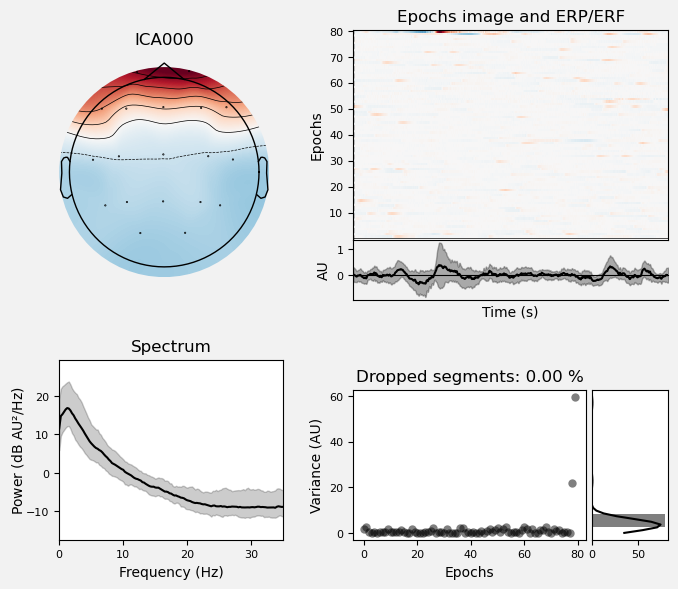

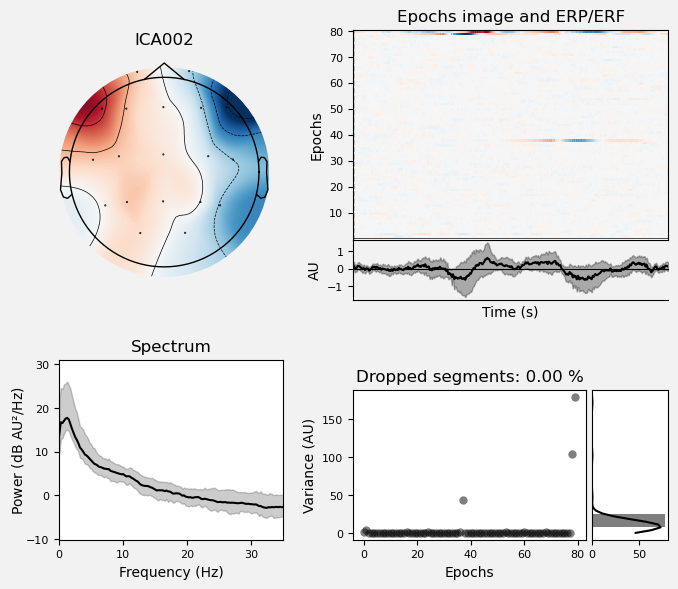

Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components

--- Applying ICA exclusion to create clean dataset ---
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Error during I

In [13]:
# Step 8: Using ICLabel to identify and exclude artifact components

import mne
import matplotlib.pyplot as plt
import numpy as np
import os
from mne.preprocessing import ICA
from mne_icalabel import label_components

# Ensure plots are displayed inline
%matplotlib inline



# Get the ICA solution
ica = epochs_with_ica.info['temp']['ica']
epochs_for_cleaning = epochs_with_ica.copy()  # Work on a copy

# --- Plotting Directory ---
ica_clean_dir = os.path.join(processed_dir, "ica_exclusion_plots")
os.makedirs(ica_clean_dir, exist_ok=True)
print(f"Saving exclusion plots to: {ica_clean_dir}")

# --- ICLabel Classification ---
print("\n--- Running ICLabel Classification ---")
ic_labels = {}

try:
    # Apply ICLabel classification
    ic_labels = label_components(epochs_for_cleaning, ica, method='iclabel')
    labels = ic_labels["labels"]
    probs = ic_labels["y_pred_proba"]
    
    print("ICLabel classifications:")
    for i, (label, prob) in enumerate(zip(labels, probs)):
        print(f"IC{i}: {label} ({prob*100:.1f}%)")
    
    # Define artifact types to exclude
    artifact_types = ['eye blink', 'heart', 'line_noise', 'channel_noise']
    
    # Set probability thresholds (adjust as needed)
    thresholds = {
        'eye blink': 0.7,         # Eye movement/blink artifacts
        'heart': 0.6,       # Cardiac artifacts
        'line_noise': 0.6,  # Power line noise (50/60Hz)
        'channel_noise': 0.6 # Single channel noise
    }
    
    # Select components to exclude based on artifact types and thresholds
    exclude_indices = []
    for i, (label, prob) in enumerate(zip(labels, probs)):
        if label in artifact_types and prob >= thresholds.get(label, 0.6):
            exclude_indices.append(i)
    
    # Sort exclude indices for cleaner output
    exclude_indices.sort()
    
    print(f"\nComponents to exclude: {exclude_indices}")
    print("Exclusion by artifact type:")
    for artifact in artifact_types:
        artifact_indices = [i for i, (label, prob) in enumerate(zip(labels, probs)) 
                          if label == artifact and prob >= thresholds.get(artifact, 0.6)]
        if artifact_indices:
            print(f"  {artifact}: {artifact_indices}")
    
    # --- Plotting and Exclusion ---
    # Plot properties of components to be excluded
    if exclude_indices:
        # Plot component properties
        fig_props = ica.plot_properties(epochs_for_cleaning, picks=exclude_indices, psd_args={'fmax': 35.})
        
        # Save component property plots
        for i, fig in enumerate(fig_props):
            comp_idx = exclude_indices[i]
            label_str = f"IC {comp_idx}: {labels[comp_idx]} ({probs[comp_idx]*100:.1f}%)"
            fig.suptitle(label_str, y=0.98)
            fig.savefig(os.path.join(ica_clean_dir, f"excluded_comp{comp_idx}.png"))
        plt.close('all')
        
        # Plot overlay of raw data before and after exclusion
        # Select 5 example epochs for demonstration
        example_epochs = min(5, len(epochs_for_cleaning))
        for epoch_idx in range(example_epochs):
            # Plot before exclusion
            fig_before = epochs_for_cleaning[epoch_idx].plot(show=False, title=f"Epoch {epoch_idx} - Before ICA cleaning")
            fig_before.savefig(os.path.join(ica_clean_dir, f"epoch{epoch_idx}_before.png"))
            plt.close(fig_before)
            
            # Apply ICA exclusion for comparison
            epochs_cleaned = epochs_for_cleaning.copy()
            ica.apply(epochs_cleaned, exclude=exclude_indices)
            
            # Plot after exclusion
            fig_after = epochs_cleaned[epoch_idx].plot(show=False, title=f"Epoch {epoch_idx} - After ICA cleaning")
            fig_after.savefig(os.path.join(ica_clean_dir, f"epoch{epoch_idx}_after.png"))
            plt.close(fig_after)
        
        # Apply ICA with exclusion to create clean dataset
        print("\n--- Applying ICA exclusion to create clean dataset ---")
        ica.apply(epochs_for_cleaning, exclude=exclude_indices)
        
        # Store excluded components in epochs info
        if 'excluded_ica_indices' not in epochs_for_cleaning.info:
            epochs_for_cleaning.info['excluded_ica_indices'] = exclude_indices
        
        # Create a plot showing power spectrum before and after
        fig_psd, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
        epochs_with_ica.plot_psd(ax=axes[0], fmax=80, show=False)
        axes[0].set_title('Before ICA cleaning')
        epochs_for_cleaning.plot_psd(ax=axes[1], fmax=80, show=False)
        axes[1].set_title('After ICA cleaning')
        fig_psd.tight_layout()
        fig_psd.savefig(os.path.join(ica_clean_dir, "psd_comparison.png"))
        plt.close(fig_psd)
        
        print(f"\nExcluded {len(exclude_indices)} components: {exclude_indices}")
        print(f"Clean epochs saved in 'epochs_cleaned'")
        
        # Store cleaned epochs
        epochs_cleaned = epochs_for_cleaning
    else:
        print("No components selected for exclusion based on current thresholds.")
        epochs_cleaned = epochs_for_cleaning

except ImportError:
    print("mne_icalabel is not installed. Please install it using: pip install mne-icalabel")
    epochs_cleaned = epochs_for_cleaning
except Exception as e:
    print(f"Error during ICLabel cleaning: {e}")
    epochs_cleaned = epochs_for_cleaning

# --- Final Summary ---
print("\n--- ICLabel Cleaning Summary ---")
print(f"Identified artifact components: {exclude_indices}")
print(f"Review the plots in: {ica_clean_dir}")
print("Proceed to the next preprocessing step with 'epochs_cleaned'")

import os
import matplotlib.pyplot as plt
%matplotlib inline
# 1. Draw all ICs off‐screen, with a fixed grid
fig_components = ica.plot_components(
    inst=raw,                # or your Epochs object
    show=False,
    title="ICA Components (red = excluded)",
    ncols=8                  # choose columns to fit your figure width
)

# 2. Loop over every axes, pick out its IC index, then:
for ax in fig_components.axes:
    title = ax.get_title()
    if title.isdigit():                # only true IC‐map axes (titles are "0", "1", …)
        comp_idx = int(title)

        # 2a) if this IC is excluded, draw a thick red border
        if comp_idx in exclude_indices:
            ax.patch.set_edgecolor('red')
            ax.patch.set_linewidth(4.0)

            # 2b) annotate inside the topo with your ICLabel info
            #    (falling back gracefully if you didn’t run ICLabel)
            label = labels[comp_idx] if 'labels' in locals() else "Excluded"
            prob  = probs[comp_idx] * 100 if 'probs' in locals() else None

            if prob is not None:
                ann = f"{label}\n({prob:.1f} %)"
            else:
                ann = label

            ax.text(
                0.5, 0.9, ann,
                transform=ax.transAxes,
                ha="center", va="top",
                color="red",
                fontsize=8,
                fontweight="bold",
                bbox=dict(facecolor="white", alpha=0.7, boxstyle="round")
            )

# 3. Finish off and save
fig_components.suptitle(
    "ICA Components (Red border + label = Excluded)",
    fontsize=18, y=0.98
)
fig_components.savefig(
    os.path.join(ica_clean_dir, "all_components_with_exclusions.png"),
    dpi=300, bbox_inches="tight"
)
plt.close(fig_components)


In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mne.viz import plot_topomap

# — Make sure these exist in your namespace:
#    ica             : your fitted ICA instance
#    raw             : your Raw or Epochs object
#    exclude_indices : list of component indices to exclude
#    labels (opt)    : ICLabel names array, same length as n_components
#    probs (opt)     : ICLabel probabilities array, same length as n_components
#    ica_clean_dir   : directory where you want to save the figure

# 1) Get the unmixing weights and channel info
weights = ica.get_components()      # shape: (n_channels, n_components)
info    = raw.info                  # or epochs.info

n_comp = weights.shape[1]
ncols  = 8                          # adjust columns to your screen/paper
nrows  = int(np.ceil(n_comp / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(2.5 * ncols, 2.5 * nrows),
    squeeze=False
)

# 2) Compute a global limit for a symmetrical color scale
vlim = np.max(np.abs(weights)) * 0.8

# 3) Loop through and plot each component
for comp_idx, ax in enumerate(axes.flat):
    if comp_idx >= n_comp:
        ax.axis('off')
        continue

    # draw the topomap with valid 'cubic' interpolation
    im, _ = plot_topomap(
        weights[:, comp_idx], info,
        axes=ax, show=False,
        cmap='RdBu_r',           # diverging map
        sensors=True,            # plot electrode dots
        outlines='head',         # supported outline option
        contours=6,              # nice contour lines
        image_interp='cubic'     # first-pass interpolation
    )
    # enforce symmetric scaling
    im.set_clim(-vlim, vlim)
    # apply matplotlib's bilinear smoothing if you like
    im.set_interpolation('bilinear')

    # title each subplot
    ax.set_title(f"IC{comp_idx:03d}", fontsize=10, pad=2)

    # highlight exclusions
    if comp_idx in exclude_indices:
        ax.patch.set_edgecolor('red')
        ax.patch.set_linewidth(3.0)

        # optional ICLabel text
        label = labels[comp_idx] if 'labels' in locals() else "Excluded"
        prob  = probs[comp_idx] * 100 if 'probs' in locals() else None
        ann   = f"{label}\n{prob:.1f} %" if prob is not None else label

        ax.text(
            0.5, 0.1, ann,
            transform=ax.transAxes,
            ha='center', va='bottom',
            color='red', fontsize=8, fontweight='bold',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round')
        )

# 4) Remove ticks & spines for a clean look
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

# 5) Add a single horizontal colorbar
cbar_ax = fig.add_axes([0.25, 0.03, 0.5, 0.03])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_title('Component amplitude (a.u.)', fontsize=10)

# 6) Super‑title, layout, save, and close
fig.suptitle(
    "ICA Components\n(red border & label = excluded)",
    fontsize=16, y=0.96
)
fig.tight_layout(rect=[0, 0.05, 1, 0.93])

os.makedirs(ica_clean_dir, exist_ok=True)
out_path = os.path.join(ica_clean_dir, "all_components_pub_ready.png")
fig.savefig(out_path, dpi=300)
plt.close(fig)

print(f"Saved publication‑ready ICA grid to:\n  {out_path}")


C:\Users\s\AppData\Local\Temp\ipykernel_35264\2509313365.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.05, 1, 0.93])


Saved publication‑ready ICA grid to:
  d:/Yann/neurotheque_resources/data/processed\ica_exclusion_plots\all_components_pub_ready.png


In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
# Instead of importing psd_welch directly, we'll use epochs.compute_psd()

# --- Inputs & Config ---
# ica: fitted ICA instance
# exclude_indices: list of IC indices (e.g., [1,2])
# epochs_with_ica: pre‑ICA Epochs (with preload=True)
# processed_dir: base directory for outputs

# 0) Sanity checks
if not hasattr(ica, 'apply'):
    raise RuntimeError("ICA instance missing—run ICA extraction first.")
if not hasattr(epochs_with_ica, 'get_data'):
    raise RuntimeError("Provide `epochs_with_ica` with preload=True.")
exclude_indices = locals().get('exclude_indices', [])
print(f"🧹 Excluding ICA components: {exclude_indices}")

# 1) Prepare output directory
out_dir = os.path.join(processed_dir, "ica_reconstruction_plots")
os.makedirs(out_dir, exist_ok=True)
print(f"📂 Saving plots to: {out_dir}")

# 2) Apply ICA on a copy to reconstruct cleaned epochs
epochs_clean = epochs_with_ica.copy()
ica.apply(epochs_clean, exclude=exclude_indices)
print("✅ ICA applied—`epochs_clean` created.")

# 3) Time‑series comparison (manual plotting)
channel = 'Cz' if 'Cz' in epochs_with_ica.ch_names else epochs_with_ica.ch_names[0]
ch_idx = epochs_with_ica.ch_names.index(channel)
times = epochs_with_ica.times
n_ex = min(5, len(epochs_with_ica))

for ep in range(n_ex):
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    data_b = epochs_with_ica.get_data()[ep, ch_idx, :]
    data_a = epochs_clean.get_data()[ep, ch_idx, :]
    ax0.plot(times, data_b); ax0.set_title(f"Epoch {ep} • {channel} • Before ICA")
    ax1.plot(times, data_a); ax1.set_title(f"Epoch {ep} • {channel} • After ICA")
    for ax in (ax0, ax1):
        ax.set_ylabel("Amplitude (µV)"); ax.grid(ls=':', alpha=0.5)
    ax1.set_xlabel("Time (s)")
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, f"epoch{ep:02d}_timeseries.png"), dpi=200)
    plt.close(fig)
    
# 4) PSD comparison using compute_psd() 
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
for ax, epc, label in zip(axes, (epochs_with_ica, epochs_clean), ("Before ICA", "After ICA")):
    # Using compute_psd with correct parameters for multitaper
    psds = epc.compute_psd(fmin=1, fmax=80, method='multitaper', 
                          n_jobs=1).get_data()
    # Convert to dB and average across epochs and channels
    psd_db = 10 * np.log10(psds.mean(axis=(0, 1)))
    # Get the frequencies from the PSD result
    freqs = epc.compute_psd(fmin=1, fmax=80, method='multitaper').freqs
    ax.plot(freqs, psd_db)
    ax.set(title=f"{label} • PSD 1–80 Hz", xlabel="Frequency (Hz)", ylabel="Power (dB)")
    ax.grid(ls=':', alpha=0.5)
fig.tight_layout()
fig.savefig(os.path.join(out_dir, "psd_comparison.png"), dpi=200)
plt.close(fig)

# 5) ERP/Evoked comparison
try:
    ev_b = epochs_with_ica.average()
    ev_a = epochs_clean.average()
    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    ev_b.plot(axes=axs[0], show=False, spatial_colors=True, titles="ERP Before ICA")
    ev_a.plot(axes=axs[1], show=False, spatial_colors=True, titles="ERP After ICA")
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, "erp_comparison.png"), dpi=200)
    plt.close(fig)
    print("🎯 ERP comparison saved.")
except Exception as e:
    print(f"⚠️ Skipping ERP comparison: {e}")

# 6) Topographic difference map - Fix title parameter
try:
    ev_diff = mne.combine_evoked([ev_a, ev_b], weights=[1, -1])
    times_tp = np.linspace(ev_diff.times[0], ev_diff.times[-1], 5)[1:-1]
    
    # Create figure with title before calling plot_topomap
    fig = plt.figure(figsize=(10, 3))
    
    # Plot topomap without title parameter
    topo_fig = ev_diff.plot_topomap(times=times_tp, ch_type='eeg', show=False, axes=fig.subplots(1, len(times_tp)))
    
    # Add title manually
    fig.suptitle("Topography: After–Before")
    fig.tight_layout()
    
    fig.savefig(os.path.join(out_dir, "topography_difference.png"), dpi=200)
    plt.close(fig)
    print("🌐 Topographic difference saved.")
except Exception as e:
    print(f"⚠️ Skipping topographic map: {e}")

# 7) Publication-quality ICA component visualization
try:
    # Create a well-formatted grid showing all components
    # First, get the unmixing matrix to know what's applied during rejection
    unmixing = ica.unmixing_matrix_
    n_components = unmixing.shape[0]
    
    # Calculate how many rows/cols we need
    n_cols = min(6, n_components)  # Max 6 components per row
    n_rows = int(np.ceil(n_components / n_cols))
    
    # Create figure for components
    fig_grid = plt.figure(figsize=(n_cols * 2.5, n_rows * 2.2))
    gs = fig_grid.add_gridspec(n_rows, n_cols)
    
    for i in range(n_components):
        ax = fig_grid.add_subplot(gs[i // n_cols, i % n_cols])
        ica.plot_components(picks=i, axes=ax, colorbar=False, show=False)
        
        # Style excluded components
        is_excluded = i in exclude_indices
        title_color = 'red' if is_excluded else 'black'
        title_weight = 'bold' if is_excluded else 'normal'
        title_text = f"IC{i}"
        if is_excluded:
            ax.set_title(title_text, color=title_color, fontweight=title_weight)
            # Add a red border
            ax.patch.set_edgecolor('red')
            ax.patch.set_linewidth(2)
            # Add "EXCLUDED" label
            ax.text(0.5, 0.05, "EXCLUDED", 
                  horizontalalignment='center',
                  verticalalignment='bottom',
                  color='red',
                  fontweight='bold',
                  fontsize=9,
                  transform=ax.transAxes,
                  bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        else:
            ax.set_title(title_text, color=title_color, fontweight=title_weight)
    
    # Add overall title
    fig_grid.suptitle(f"ICA Components (Red = Excluded: {exclude_indices})", 
                    fontsize=14, y=0.98)
    
    # Adjust spacing and save
    fig_grid.tight_layout(rect=[0, 0.05, 1, 0.93])
    fig_grid.savefig(os.path.join(out_dir, "all_components_pub_ready.png"), dpi=300)
    plt.close(fig_grid)
    print(f"Saved publication‑ready ICA grid to:\n  {os.path.join(out_dir, 'all_components_pub_ready.png')}")
except Exception as e:
    print(f"⚠️ Could not create component grid: {e}")
    
# 8) Final report - Use 'temp' subdict for custom info
# Store excluded components in epochs info['temp']
if 'temp' not in epochs_clean.info:
    epochs_clean.info['temp'] = {}
epochs_clean.info['temp']['excluded_ica_indices'] = exclude_indices

print("\n🔔 ICA Reconstruction complete.")
print(f"  • Clean epochs: `epochs_clean`")
print(f"  • All plots in: {out_dir}")
print(f"  • Excluded ICA components: {exclude_indices} (stored in epochs_clean.info['temp']['excluded_ica_indices'])")

🧹 Excluding ICA components: [0, 2]
📂 Saving plots to: d:/Yann/neurotheque_resources/data/processed\ica_reconstruction_plots
Applying ICA to Epochs instance
    Transforming to ICA space (18 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
✅ ICA applied—`epochs_clean` created.
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows


C:\Users\s\AppData\Local\Temp\ipykernel_35264\735117376.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


🎯 ERP comparison saved.
⚠️ Skipping topographic map: You must provide 4 axes (one for each time plus one for the colorbar), got 3.
Saved publication‑ready ICA grid to:
  d:/Yann/neurotheque_resources/data/processed\ica_reconstruction_plots\all_components_pub_ready.png

🔔 ICA Reconstruction complete.
  • Clean epochs: `epochs_clean`
  • All plots in: d:/Yann/neurotheque_resources/data/processed\ica_reconstruction_plots
  • Excluded ICA components: [0, 2] (stored in epochs_clean.info['temp']['excluded_ica_indices'])


In [ ]:
# --- Re‑epoching using the original continuous raw (no DataFrame round‑trip) ---
from scr.steps.epoching import EpochingStep

# 1) Start from your pre‑processed raw that still has events
if 'raw' not in locals():
    raise ValueError("Original raw not found – make sure `raw` is in scope")
raw_clean = raw.copy()

# 2) Apply ICA exclusions directly on that raw
ica.apply(raw_clean, exclude=exclude_indices)

# 3) (Optional) sanity‑check that your triggers survived:
events_after_ica = mne.find_events(raw_clean, stim_channel='Trigger', shortest_event=1)
print(f"[DEBUG] Events after ICA: {len(events_after_ica)}")

# 4) Now epoch around your true 5‑point test triggers
epoching_params = {
    "task_type": "5pt",
    "stim_channel": "Trigger",
    "trigger_ids": {"trigger_id": 8},
    "epoch_params": {
        "tmin": -0.2,
        "tmax":  1.0,
        "baseline": (None, 0.0),
        "preload": True,
        "reject_by_annotation": True
    },
    "add_annotations": True,
    "returns_epochs": True
}
epoching_step = EpochingStep(params=epoching_params)
epochs_clean = epoching_step.run(raw_clean)

print(f"[DEBUG] Re‑created {len(epochs_clean)} epochs for the 5‑point task")


In [ ]:
# Apply AutoReject to the ICA-cleaned data using the AutoRejectStep class
import mne
import numpy as np
import matplotlib.pyplot as plt
import os
from scr.steps.autoreject import AutoRejectStep

print("Applying AutoReject to clean ICA-processed data...")

# Check if we have the cleaned epochs from ICA
if 'epochs_clean' not in locals():
    raise ValueError("Cannot find 'epochs_clean'. Run ICA reconstruction first.")

# Create a specific directory for these autoreject plots to avoid overwriting
post_ica_ar_dir = os.path.join(processed_dir, "autoreject_post_ica")
os.makedirs(post_ica_ar_dir, exist_ok=True)

# Configure the AutoReject parameters with unique filenames
ar_params = {
    "ar_params": {
        "n_interpolate": [1, 2, 3, 4],  # Number of channels to interpolate
        "consensus": None,  # Use automatic optimization
        "thresh_method": "bayesian_optimization",
        "n_jobs": 1,  # Increase for faster processing if you have multiple cores
    },
    "plot_results": True,
    "interactive": True,  # Set to True to see plots interactively
    "plot_dir": post_ica_ar_dir,  # Use different directory
    "mode": "fit",  # Use "fit" to only identify bad epochs without modifying data
    "store_reject_log": True, # Store rejection information for later use
    "file_prefix": "ar_post_ica",  # Unique prefix for this run
    "output_dir": post_ica_ar_dir,  # Also save any files to the new directory
    "subject_id": "01",  # Change if needed
    "session_id": "001",  # Change if needed
    "run_id": "01_post_ica"  # Add a suffix to make filenames unique
}

# Create the AutoReject step
ar_step = AutoRejectStep(params=ar_params)

# Run AutoReject on the cleaned epochs
print(f"Running AutoReject on {len(epochs_clean)} epochs...")
epochs_clean_ar = ar_step.run(epochs_clean)

# Verify that bad epochs were identified
if 'temp' in epochs_clean_ar.info and 'autoreject_bad_epochs' in epochs_clean_ar.info['temp']:
    bad_epochs = epochs_clean_ar.info['temp']['autoreject_bad_epochs']
    print(f"\nAutoReject identified {len(bad_epochs)} bad epochs out of {len(epochs_clean)} ({len(bad_epochs)/len(epochs_clean)*100:.1f}%)")
else:
    print("Warning: No bad epochs were identified or stored in epochs_clean_ar.info['temp']")

# Drop the bad epochs to create a clean dataset for re-epoching
if 'temp' in epochs_clean_ar.info and 'autoreject_bad_epochs' in epochs_clean_ar.info['temp']:
    bad_indices = epochs_clean_ar.info['temp']['autoreject_bad_epochs']
    
    if bad_indices:
        # Create a copy to drop the bad epochs
        epochs_clean_without_bad = epochs_clean.copy().drop(bad_indices)
        print(f"Dropped {len(bad_indices)} bad epochs. Remaining: {len(epochs_clean_without_bad)} good epochs")
    else:
        epochs_clean_without_bad = epochs_clean.copy()
        print("No bad epochs to drop. Using all epochs for further processing.")
else:
    print("Warning: Could not find bad epoch indices. Using all epochs for further processing.")
    epochs_clean_without_bad = epochs_clean.copy()

# Save the result for next steps (re-epoching with regression-based baseline)
epochs_clean_ar = epochs_clean_without_bad.copy()
print("\nAutoReject processing complete!")
print("Clean epochs stored in 'epochs_clean_ar'")
print(f"AutoReject figures saved to: {post_ica_ar_dir}")
print("You can now proceed with re-epoching and regression-based baseline correction.")

In [24]:
import os
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import tfr_morlet
from fooof import FOOOF
# import statsmodels.formula.api as smf
# from pygam import GAM, s


In [ ]:
epochs_clean.events

In [ ]:
import numpy as np

# 1. Compute TFR and apply log‑ratio baseline
freqs = np.logspace(np.log10(4), np.log10(40), num=30)
n_cycles = freqs / 2.0
tfr = epochs_clean_ar.compute_tfr(
    method='morlet',
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=False,
    decim=2,
    average=True
)
tfr_log = tfr.copy().apply_baseline(baseline=(None, 0), mode='logratio')

# 2. Define color limits (e.g., ±1.5 log‑ratio units)
vmin, vmax = -1.5, 1.5

# 3. Plot ERSP at Cz
fig = tfr_log.plot(
    picks=['Cz'],
    baseline=None,           # already applied
    mode='mean',             # data already baseline‑corrected
    dB=False,                # logratio data—not raw power
    cmap='RdBu_r',
    vlim=(vmin, vmax),       # replaces vmin/vmax
    colorbar=True,
    title='Log‑Ratio ERSP at Cz (4–40 Hz)'
)


In [ ]:
tfr_log.plot(picks=['Cz', 'C3', 'C4'],
             combine='mean',  # average across picks
             vlim=(vmin, vmax),
             cmap='viridis')


In [ ]:
import numpy as np
from fooof import FOOOF

# --- 1) Compute PSD per epoch with Welch (zero‑padded if desired) ---
spec = epochs_clean_ar.compute_psd(
    method    = 'welch',
    fmin      = freqs.min(),
    fmax      = freqs.max(),
    n_fft     = 512,                   # zero-pad segments
    n_per_seg = epochs_clean_ar.get_data().shape[-1]  # full epoch length
)
psds, psd_freqs = spec.get_data(return_freqs=True)  # → (n_epochs, n_ch, n_psd_freqs)

# --- 2) Average PSD across channels to get a single spectrum per epoch ---
# shape: (n_epochs, n_psd_freqs)
mean_psds = psds.mean(axis=1)

# --- 3) Fit FOOOF to extract aperiodic (_ap_fit) and periodic (_peak_fit) curves ---
# Compute frequency resolution to set reasonable peak_width_limits
epoch_len = epochs_clean_ar.tmax - epochs_clean_ar.tmin         # e.g. ≈1.707 s
freq_res  = 1.0 / epoch_len                          # ≈0.586 Hz
min_w     = 2 * freq_res                             # ≈1.17 Hz lower bound
max_w     = 8                                        # upper bound

fooof = FOOOF(aperiodic_mode='knee',
              peak_width_limits=[min_w, max_w])

# Preallocate arrays
n_epochs    = mean_psds.shape[0]
n_freqs_psd = len(psd_freqs)
aperiodic_psd = np.zeros((n_epochs, n_freqs_psd))
periodic_psd  = np.zeros((n_epochs, n_freqs_psd))

for ei in range(n_epochs):
    fooof.fit(psd_freqs, mean_psds[ei])       # fit 1/f + peaks :contentReference[oaicite:0]{index=0}
    aperiodic_psd[ei] = fooof._ap_fit         # the aperiodic component :contentReference[oaicite:1]{index=1}
    periodic_psd[ei]  = fooof._peak_fit       # the sum of all Gaussian peak fits :contentReference[oaicite:2]{index=2}

# --- 4) (Optional) Compute the grand average across epochs ---
mean_aperiodic = aperiodic_psd.mean(axis=0)
mean_periodic  = periodic_psd.mean(axis=0)

# --- 5) Plot the results ---
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(psd_freqs, mean_aperiodic, label='Aperiodic (1/f)', linewidth=2)
plt.plot(psd_freqs, mean_periodic,  label='Periodic (peaks)', linestyle='--', linewidth=2)
plt.plot(psd_freqs, mean_aperiodic + mean_periodic,
         label='Reconstructed PSD', color='k', alpha=0.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('FOOOF‑derived PSD Components')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from fooof import FOOOF

# --- 1) Compute your grand‑average PSD in linear µV²/Hz ---
# psds: (n_epochs, n_ch, n_freqs) in V²/Hz as returned by MNE
mean_psd_V2 = psds.mean(axis=(0,1))           # average over epochs & channels
mean_psd_uV2 = mean_psd_V2 * 1e12             # convert to µV²/Hz

# --- 2) Guard against zeros or negatives (avoid log10(0)) ---
eps = np.finfo(float).eps
mean_psd_uV2 = np.maximum(mean_psd_uV2, eps)

# --- 3) Fit FOOOF on the **linear** spectrum! ---
foo = FOOOF()

    # aperiodic_mode='fixed',
    # peak_width_limits=[1.5, 8],
    # min_peak_height=0.1,
    # peak_threshold=2.0
foo.fit(psd_freqs, mean_psd_uV2)  # <-- pass linear units here

# --- 4) Extract fits (in log10 units) and convert to dB for plotting ---
ap_log10  = foo._ap_fit                  # 1/f fit in log10(power)
pk_log10  = foo._peak_fit                # sum of Gaussians in log10(power)

# convert to dB: 10 * log10(power_linear)  ->  10 * (log10(power_linear))
# since log10(power_linear) == (foo._ap_fit) in our case
ap_dB     = 10 * ap_log10
pk_dB     = 10 * pk_log10
recon_dB  = ap_dB + pk_dB

# --- 5) Diagnostic overlay using FOOOF’s built‑in plot ---
foo.plot(plt_log=False)  # shows raw vs. ap/peak fits in log10 space

# --- 6) Semilog‑x plot in dB space for publication ─────────────────────────
fig, ax = plt.subplots(figsize=(6,4))
ax.semilogx(psd_freqs, 10 * np.log10(mean_psd_uV2),  label='Mean PSD (dB)',    lw=1)
ax.semilogx(psd_freqs, ap_dB,                     label='Aperiodic fit (dB)',lw=2)
ax.semilogx(psd_freqs, recon_dB,                 '--', label='Reconstructed',   lw=1, color='gray')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB µV²/Hz)')
ax.set_title('FOOOF Fit on Grand‑Average PSD')
ax.legend(loc='upper right')
ax.grid(True, which='both', ls=':', alpha=0.5)
plt.tight_layout()
plt.show()

# --- 7) Print out fit quality & peak params ---
print(f"R² : {foo.r_squared_:.3f}    Error : {foo.error_:.3f}")
print("Peaks detected (center Hz, height dB, width Hz):")
for center, height, width in foo.gaussian_params_:
    print(f"  {center:5.2f} Hz, +{10*height:4.1f} dB, width={width:4.1f} Hz")


In [ ]:
# --- A) Compute draw_time for each kept epoch from epochs_clean_ar -------

# 1) Get all code‑8 events from the original raw you used for these epochs
raw_events = mne.find_events(raw_clean, stim_channel='Trigger', shortest_event=1)
events8    = raw_events[raw_events[:, 2] == 8]

# 2) Pair them: even indices = onset, odd = first touch
if len(events8) % 2 != 0:
    raise RuntimeError(f"Found {len(events8)} code‑8 events; need an even number for pairing")
onsets  = events8[0::2, 0]
touches = events8[1::2, 0]

sfreq = raw_clean.info['sfreq']

# 3) For each *kept* epoch, look up its event sample in epochs_clean_ar.events[:,0]
epoch_events = epochs_clean_ar.events[:, 0]  # sample indices for each epoch

draw_times = []
for samp in epoch_events:
    # find which onset matches this epoch
    idx = np.where(onsets == samp)[0]
    if idx.size:
        draw_times.append((touches[idx[0]] - onsets[idx[0]]) / sfreq)
    else:
        # no matching onset (shouldn't happen if epoching used those triggers)
        draw_times.append(np.nan)

draw_times = np.array(draw_times)


# --- B) Time‑resolved FOOOF around each epoch ------------------------

win_size, win_step = 0.5, 0.1   # seconds
fmin, fmax        = 3.0, 40.0   # Hz
sfreq             = epochs_clean_ar.info['sfreq']
n_fft             = int(win_size * sfreq * 2)
step_samps        = int(win_step * sfreq)
half_win          = int(win_size * sfreq / 2)
win_size      = 1.0       # seconds
freq_res      = 1.0 / win_size
min_peak_w    = 2 * freq_res  # ≳2 Hz
trial_ids, times = [], []
aperiod_exps, mu_heights = [], []

for tidx in range(n_epochs):
    data = epochs_clean_ar.get_data()[tidx]  # shape (n_ch, n_times)
    centers = np.arange(half_win, data.shape[1] - half_win, step_samps)
    for c in centers:
        seg = data[:, c-half_win : c+half_win]
        seg_len = seg.shape[-1]

        # Welch PSD with zero‑padding
        psd, freqs = mne.time_frequency.psd_array_welch(
            seg,
            sfreq=sfreq,
            fmin=fmin, fmax=fmax,
            n_fft=n_fft,
            n_per_seg=seg_len,
            n_overlap=0,
            average='mean'
        )
        mean_psd = psd.mean(axis=0) * 1e12  # µV²/Hz

        # Fit FOOOF
        fg = FOOOF(
            aperiodic_mode='fixed',
            peak_width_limits=[min_peak_w, 8.0]
        )
        fg.fit(freqs, mean_psd)

        trial_ids.append(tidx)
        times.append((c - half_win) / sfreq)
        aperiod_exps.append(fg.aperiodic_params_[1])
        mu_idx = np.where((fg.gaussian_params_[:,0] >= 8) &
                          (fg.gaussian_params_[:,0] <= 13))[0]
        mu_heights.append(fg.gaussian_params_[mu_idx,1].mean() if mu_idx.size else np.nan)

df_fooof = pd.DataFrame({
    'trial':         trial_ids,
    'time_rel':      times,
    'aperiodic_exp': aperiod_exps,
    'mu_height':     mu_heights
})


# --- C) Collapse to per‑trial & attach draw_time ---------------------

mask = (df_fooof['time_rel'] >= -0.2) & (df_fooof['time_rel'] <= 0.8)
per_trial = (df_fooof[mask]
             .groupby('trial')
             .agg({'aperiodic_exp':'mean', 'mu_height':'mean'})
             .reset_index())

per_trial['draw_time'] = draw_times  # aligned by index order


# --- D1) Correlation: μ‑height vs. draw_time ------------------------

r = np.corrcoef(per_trial['mu_height'], per_trial['draw_time'])[0,1]
print(f"Pearson r (μ‑height vs. draw_time) = {r:.2f}")

plt.figure(figsize=(5,4))
plt.scatter(per_trial['mu_height'], per_trial['draw_time'], c='C0')
plt.xlabel('Mean μ‑Height (dB)')
plt.ylabel('Draw Time (s)')
plt.title('μ‑Power vs. Draw Time')
plt.tight_layout()
plt.show()


# --- D2) Early vs. Late session comparison ------------------------

mid = n_epochs // 2
early = per_trial.iloc[:mid]
late  = per_trial.iloc[mid:]

print("Early session:")
print(f"  Exponent = {early['aperiodic_exp'].mean():.3f} ± {early['aperiodic_exp'].std():.3f}")
print(f"  μ‑Height = {early['mu_height'].mean():.3f} ± {early['mu_height'].std():.3f}")

print("Late session:")
print(f"  Exponent = {late['aperiodic_exp'].mean():.3f} ± {late['aperiodic_exp'].std():.3f}")
print(f"  μ‑Height = {late['mu_height'].mean():.3f} ± {late['mu_height'].std():.3f}")

plt.figure(figsize=(6,4))
plt.bar(['Early','Late'],
        [early['aperiodic_exp'].mean(), late['aperiodic_exp'].mean()],
        yerr=[early['aperiodic_exp'].std(), late['aperiodic_exp'].std()])
plt.ylabel('Aperiodic Exponent')
plt.title('Early vs. Late 1/f Exponent')
plt.tight_layout()
plt.show()


# --- D3) GLMM: predict draw_time from spectral features -------------

model = mixedlm("draw_time ~ mu_height + aperiodic_exp",
                per_trial, groups=per_trial.index)  # single-subject grouping
res = model.fit(method='lbfgs')
print(res.summary())


# --- E) Grand-average PSD and FOOOF fit -----------------------------

# Compute PSD across all epochs
spec = epochs_clean_ar.compute_psd(
    fmin=fmin, fmax=fmax,
    method='welch',
    n_fft=n_fft,
    n_overlap=0
)
psds = spec.get_data()     # shape: (n_epochs, n_ch, n_freqs)
psd_freqs = spec.freqs     # frequency vector

# 1) Grand-average PSD in linear µV²/Hz
mean_psd_V2  = psds.mean(axis=(0,1))
mean_psd_uV2 = mean_psd_V2 * 1e12
eps = np.finfo(float).eps
mean_psd_uV2 = np.maximum(mean_psd_uV2, eps)

# 2) Fit FOOOF on linear spectrum
foo = FOOOF()
foo.fit(psd_freqs, mean_psd_uV2)

# 3) Extract and convert to dB
ap_log10  = foo._ap_fit
pk_log10  = foo._peak_fit
ap_dB     = 10 * ap_log10
pk_dB     = 10 * pk_log10
recon_dB  = ap_dB + pk_dB

# 4) Diagnostic overlay
foo.plot(plt_log=False)

# 5) Publication-style semilog plot
fig, ax = plt.subplots(figsize=(6,4))
ax.semilogx(psd_freqs, 10*np.log10(mean_psd_uV2),   label='Mean PSD (dB)',    lw=1)
ax.semilogx(psd_freqs, ap_dB,                      label='Aperiodic fit (dB)',lw=2)
ax.semilogx(psd_freqs, recon_dB, '--',             label='Reconstructed',   lw=1, color='gray')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power (dB µV²/Hz)')
ax.set_title('FOOOF Fit on Grand‑Average PSD')
ax.legend(loc='upper right')
ax.grid(True, which='both', ls=':', alpha=0.5)
plt.tight_layout()
plt.show()

# 6) Print fit quality and peaks
print(f"R² : {foo.r_squared_:.3f}    Error : {foo.error_:.3f}")
print("Peaks detected (center Hz, height dB, width Hz):")
for center, height, width in foo.gaussian_params_:
    print(f"  {center:5.2f} Hz, +{10*height:4.1f} dB, width={width:4.1f} Hz")


In [ ]:
# Re-epoching the ICA-cleaned data using epoching.py with regression-based baseline correction
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scr.steps.epoching import EpochingStep

# --- 1. Get the original raw data ---
print("Looking for raw data to re-epoch...")

# We need to use the original raw data, not try to reconstruct it from epochs
# Option 1: If original raw data is available in a variable
if 'raw' in locals():
    print("Found original raw data, applying ICA solution to it")
    raw_clean = raw.copy()
    # Apply the ICA solution with exclusions to the raw data
    ica.apply(raw_clean, exclude=exclude_indices)
    
# Option 2: If epochs_with_ica is available (the original epochs before ICA cleaning)
elif 'epochs_with_ica' in locals():
    print("Found original epochs before ICA, creating raw data from it")
    raw_clean = epochs_with_ica.copy()
    # Apply ICA cleaning
    ica.apply(raw_clean, exclude=exclude_indices)
    # Convert to raw using MNE's to_data_frame and from_data_frame
    data_df = raw_clean.to_data_frame()
    # Create a raw object from the dataframe
    raw_clean = mne.io.RawArray(
        np.array(data_df.iloc[:, 1:].T),  # Skip the time column
        info=raw_clean.info.copy(),
        first_samp=int(raw_clean.times[0] * raw_clean.info['sfreq'])
    )
    
# Option 3: If epochs_clean is available but we need a proper conversion method
elif 'epochs_clean' in locals():
    print("Found ICA-cleaned epochs, properly converting to continuous")
    # Get data dimensions
    n_epochs, n_channels, n_times = epochs_clean.get_data().shape
    
    # Concatenate all epochs along the time axis
    data = np.concatenate(epochs_clean.get_data(), axis=1)
    
    # Create a new info structure
    info = epochs_clean.info.copy()
    
    # Create raw object
    raw_clean = mne.io.RawArray(data, info)
    
else:
    raise ValueError("Cannot find source data for re-epoching. Need raw, epochs_with_ica, or properly converted epochs_clean.")

print(f"Created continuous data with length {raw_clean.times[-1]:.2f}s")


# --- 2. Set up EpochingStep for 5-point test ---
# Configure the epoching parameters
epoching_params = {
    "task_type": "5pt",  # Specifically use the five-point test epoching
    "trigger_ids": {"trigger_id": 8},  # Default 5PT trigger ID 
    "stim_channel": "Trigger",  # Change if your trigger channel has a different name
    "epoch_params": {
        "tmin": -0.2,  # Start time before trigger (seconds)
        "tmax": 2.0,   # End time after trigger (seconds)
        "baseline": None,  # No traditional baseline - we'll use regression later
        "preload": True,
        "reject_by_annotation": True
    },
    "returns_epochs": True,
    "visualize_events": True,
    "plot_params": {
        "duration": 15.0, 
        "tstart": 0.0,
        "interactive": True,
        "save_plots": True,
        "save_dir": os.path.join(processed_dir, "figures/events")
    }
}

# Create the epoching step
epoching_step = EpochingStep(params=epoching_params)

# --- 3. Run the epoching step on the clean raw data ---
print("Running 5-point test epoching...")
epochs_5pt = epoching_step.run(raw_clean)

print(f"Created {len(epochs_5pt)} epochs for 5-point test")

# --- 4. Apply regression-based baseline correction ---
print("\nApplying regression-based baseline correction...")

# # Define the baseline period
# baseline = (epochs_5pt.tmin, 0)  # From start of epoch to stimulus onset

# # Pick a representative channel for demonstration
# ch = 'Cz' if 'Cz' in epochs_5pt.ch_names else epochs_5pt.ch_names[0]
# print(f"Using channel {ch} for baseline regression demonstration")

# # Create the baseline predictor
# baseline_predictor = (
#     epochs_5pt.copy()
#     .crop(*baseline)
#     .pick([ch])
#     .get_data(copy=False)  # convert to NumPy array
#     .mean(axis=-1)         # average across timepoints
#     .squeeze()             # only 1 channel, so remove singleton dimension
# )
# baseline_predictor *= 1e6  # convert V → μV

# # Create a design matrix with:
# # 1. Predictor for our condition (all 'onset' for 5PT)
# # 2. Predictor for baseline effect
# design_matrix = np.vstack([
#     np.ones(len(epochs_5pt)),  # Our condition (all same type)
#     baseline_predictor         # Baseline values
# ]).T

# # Fit the regression model
# reg_model = mne.stats.linear_regression(
#     epochs_5pt, design_matrix, names=["condition", "baseline"]
# )

# # --- 5. Compare traditional vs. regression-based baseline correction ---
# print("\nComparing traditional vs. regression-based baseline correction...")

# # Apply traditional baseline correction to a copy
# epochs_traditional = epochs_5pt.copy().apply_baseline(baseline)

# # Plot the baseline regressor to show its time-varying effect
# effect_of_baseline = reg_model["baseline"].beta
# fig_baseline = effect_of_baseline.plot(
#     picks=ch,
#     hline=[1.0],  # Show horizontal line at β=1 (traditional baseline assumption)
#     units=dict(eeg=r"$\beta$ value"),
#     titles=dict(eeg=ch),
#     selectable=False
# )

# # Save the baseline effect figure
# fig_baseline.savefig(os.path.join(processed_dir, "baseline_regression_effect.png"), dpi=300)

# # Compare the ERPs from both methods
# fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# # Plot without baseline correction
# epochs_5pt.average().plot(picks=[ch], axes=axes[0], show=False)
# axes[0].set_title(f'No baseline correction - {ch}')

# # Plot with traditional baseline correction
# epochs_traditional.average().plot(picks=[ch], axes=axes[1], show=False)
# axes[1].set_title(f'Traditional baseline correction - {ch}')

# # Plot with regression-based baseline correction (the "condition" effect)
# reg_model["condition"].beta.plot(picks=[ch], axes=axes[2], show=False)
# axes[2].set_title(f'Regression-based baseline correction - {ch}')

# plt.tight_layout()
# plt.savefig(os.path.join(processed_dir, "baseline_comparison.png"), dpi=300)
# plt.show()

# # Store the results - create new epochs object with regression-based baseline correction
# # Extract the "condition" effect as our cleaned signal
# epochs_5pt_reg_baseline = epochs_5pt.copy()

# # Get indices of EEG channels
# eeg_indices = mne.pick_types(epochs_5pt.info, eeg=True, exclude=[])

# # Apply correction only to EEG channels
# for eeg_idx in eeg_indices:
#     epochs_5pt_reg_baseline._data[:, eeg_idx, :] = reg_model["condition"].beta.data[eeg_idx]

# print("\nEpoching with regression-based baseline correction complete!")
# print("Results stored in 'epochs_5pt_reg_baseline'")

# # Optional: Plot the time course of a few example epochs to see the effect
# fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
# n_examples = min(3, len(epochs_5pt))

# for i in range(n_examples):
#     # Select single epoch data for the chosen channel
#     ch_idx = epochs_5pt.ch_names.index(ch)
    
#     # Plot original data
#     t = epochs_5pt.times
#     axes[0].plot(t, epochs_5pt.get_data()[i, ch_idx], label=f'Epoch {i}')
    
#     # Plot traditional baseline
#     axes[1].plot(t, epochs_traditional.get_data()[i, ch_idx], label=f'Epoch {i}')
    
#     # Plot regression-corrected
#     axes[2].plot(t, epochs_5pt_reg_baseline.get_data()[i, ch_idx], label=f'Epoch {i}')

# axes[0].set_title('No Baseline Correction')
# axes[1].set_title('Traditional Baseline Correction')  
# axes[2].set_title('Regression-based Baseline Correction')

# for ax in axes:
#     ax.set_ylabel('Amplitude (μV)')
#     ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
#     ax.grid(True, alpha=0.3)

# axes[2].set_xlabel('Time (s)')
# plt.tight_layout()
# plt.savefig(os.path.join(processed_dir, "example_epochs_baseline_comparison.png"), dpi=300)
# plt.show()

In [ ]:
# Step 9: Apply Baseline Correction after AutoReject and ICA
import os
import numpy as np
import matplotlib.pyplot as plt
from scr.steps.baseline_correction import BaselineCorrectionStep
import pandas as pd


print("Step 9: Applying baseline correction to cleaned epochs...")

# # Check if we have the cleaned epochs from AutoReject
# if 'epochs_clean_ar' not in locals():
#     raise ValueError("Cannot find 'epochs_clean_ar'. Run AutoReject first.")

# Define the baseline period
baseline_period = (-0.2, 0)  # 200ms before stimulus onset

# Setup parameters for the baseline correction step
baseline_params = {
    "method": "glmm",  # Use regression-based correction (recommended)
    # Other options: 'classic', 'huber', 'ransac', 'all' (to try all methods)
    "baseline": baseline_period,
    "plot_comparison": True,
    "save_plots": True,
    "plot_dir": os.path.join(processed_dir, "baseline_correction"),
    "interactive": True,  # Set to True to see plots interactively
    "channel_for_demo": "",  # Use central electrode for visualization
    "plot_title": "Baseline Correction Comparison (Post-ICA and AutoReject)",
    "subject_id": "01",
    "session_id": "001"
}


# suppose epochs_5pt is your MNE Epochs
n_epochs = len(epochs_5pt)
epochs_5pt.metadata = pd.DataFrame({
    'subject': ['S01'] * n_epochs
})
# Create and run the BaselineCorrectionStep
baseline_step = BaselineCorrectionStep(params=baseline_params)

# Apply baseline correction - if method is 'all', returns dict of all methods
# Otherwise returns epochs with the selected correction method applied
print(f"Applying {baseline_params['method']} baseline correction...")
if baseline_params['method'] == 'all':
    # Apply all methods and get a dictionary of results
    baseline_results = baseline_step.run(epochs_5pt)
    # Select one method as our preferred result (regression is recommended)
    epochs_baseline = baseline_results['regression']
    print(f"Applied multiple baseline correction methods. Using 'regression' as the final result.")
else:
    # Apply a single method
    epochs_baseline = baseline_step.run(epochs_5pt)
    print(f"Applied {baseline_params['method']} baseline correction.")

# Save the corrected epochs for further analysis
epochs_final = epochs_baseline.copy()
print(f"Final cleaned, baseline-corrected epochs stored in 'epochs_final'")
print(f"Dataset contains {len(epochs_final)} epochs with shape {epochs_final.get_data().shape}")

# Optionally: Re-reference to average after baseline correction
# epochs_final.set_eeg_reference('average', projection=False)

# Create a final plot to show the complete processing pipeline
ch = 'P3' if 'P3' in epochs_final.ch_names else epochs_final.ch_names[0]
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Plot the original data
if 'epochs' in locals():
    epochs.average().plot(picks=[ch], axes=axes[0], show=False)
    axes[0].set_title(f'Original Data (Before ICA and AutoReject)')
else:
    axes[0].set_title('Original Data not available')
    axes[0].text(0.5, 0.5, 'Data not in memory', 
                ha='center', va='center', transform=axes[0].transAxes)

# Plot after ICA
if 'epochs_clean' in locals():
    epochs_clean.average().plot(picks=[ch], axes=axes[1], show=False)
    axes[1].set_title(f'After ICA Cleaning')
else:
    axes[1].set_title('ICA Data not available')
    axes[1].text(0.5, 0.5, 'Data not in memory', 
                ha='center', va='center', transform=axes[1].transAxes)
    
# Plot final data
epochs_final.average().plot(picks=[ch], axes=axes[2], show=False)
axes[2].set_title(f'Final Data (After ICA, AutoReject, and Baseline Correction)')

# Add vertical line at stimulus onset and mark baseline period
for ax in axes:
    ax.axvline(0, color='k', linestyle='--', alpha=0.5)
    ax.axvspan(baseline_period[0], baseline_period[1], color='gray', 
              alpha=0.2, label='Baseline period')
    ax.set_ylabel('Amplitude (μV)')
    ax.grid(True, linestyle=':', alpha=0.3)

axes[2].set_xlabel('Time (s)')
plt.tight_layout()

# Save the summary plot
summary_dir = os.path.join(processed_dir, "summary_plots")
os.makedirs(summary_dir, exist_ok=True)
plt.savefig(os.path.join(summary_dir, "full_preprocessing_pipeline.png"), dpi=300)
plt.show()

print("\nPreprocessing pipeline complete!")
print(f"Final results stored in 'epochs_final' variable")

In [ ]:
import os
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import tfr_morlet
from fooof import FOOOF
import statsmodels.formula.api as smf
from pygam import GAM, s


In [ ]:

# --- 1. Re-epoch the ICA-cleaned data as before ---
# [Your existing raw_clean & epoching_step code here]
epochs_5pt = epoching_step.run(raw_clean)
print(f"Created {len(epochs_5pt)} epochs for 5-point test")

# --- 2. Apply traditional pre-stimulus baseline correction ---
# Subtract mean from –0.2 s to 0 s in each epoch (DC offset removal) :contentReference[oaicite:0]{index=0}
epochs_5pt = epochs_5pt.apply_baseline(baseline=(-0.2, 0.0))

# --- 3. Compute single-trial ERSP with log-ratio normalization ---
freqs = np.logspace(np.log10(4), np.log10(40), num=30)  # 4–40 Hz :contentReference[oaicite:1]{index=1}
n_cycles = freqs / 2.0                                     # ~2 cycles per freq
tfr = tfr_morlet(epochs_5pt, freqs=freqs, n_cycles=n_cycles,
                 use_fft=True, return_itc=False, decim=2)  # :contentReference[oaicite:2]{index=2}

# Log-ratio over full epoch (trial‑wise centring) :contentReference[oaicite:3]{index=3}
tfr_log = tfr.copy().apply_baseline(baseline=(None, None), mode='logratio')

# --- 4. Optional: Remove aperiodic 1/f component using FOOOF ---
# (uncomment to use)
# fooof = FOOOF(aperiodic_mode='knee', peak_width_limits=[1, 8])
# psds, psd_freqs = mne.time_frequency.psd_welch(epochs_5pt,
#                                               fmin=freqs.min(),
#                                               fmax=freqs.max(),
#                                               n_fft=256)
# per_epoch_clean = []
# for ep_psd in psds:
#     fooof.fit(psd_freqs, ep_psd.mean(axis=1))
#     # Subtract the aperiodic fit from each freq
#     ap_fit = fooof._ap_fit
#     per_epoch_clean.append(ep_psd - ap_fit[:, np.newaxis])
# tfr_log.data = np.array(per_epoch_clean)[..., :, :tfr_log.data.shape[-1]]
# :contentReference[oaicite:4]{index=4}

# --- 5. Prepare data for mixed‐effects or GAM analysis ---
# Flatten power (channels × freqs × times) into long‐form DataFrame
times = tfr_log.times
n_epochs, n_chans, n_freqs, n_times = tfr_log.data.shape

# Example: average over channels first, then stack
power_flat = tfr_log.data.mean(axis=1).reshape(n_epochs * n_freqs * n_times)
phase_flat = np.tile(np.repeat(times, n_freqs), n_epochs)
freq_flat  = np.tile(np.tile(freqs, n_times), n_epochs)
epoch_idx  = np.repeat(np.arange(n_epochs), n_freqs * n_times)
cond_flat  = np.repeat(epochs_5pt.events[:, 2], n_freqs * n_times)
# Assuming single subject pipeline; add subject ID if multiple
subj_flat  = np.repeat('subj1', len(power_flat))

df = pd.DataFrame({
    'power_dB': power_flat,
    'phase': phase_flat,
    'frequency': freq_flat,
    'condition': cond_flat,
    'epoch': epoch_idx,
    'subject': subj_flat
})

# --- 6. Fit a linear mixed model (GLMM) ---
# power_dB ~ phase * condition + (1|subject) :contentReference[oaicite:5]{index=5}
md = smf.mixedlm("power_dB ~ phase * C(condition)", df,
                 groups=df["subject"])
mdf = md.fit()
print(mdf.summary())

# --- 7. Or fit a GAM with smooth phase effects ---
# power_dB ~ s(phase, by=condition) + s(subject, bs='re') :contentReference[oaicite:6]{index=6}
gam = GAM(s('phase', by='condition') + s('subject', bs='re')).fit(
    df[['power_dB', 'phase', 'condition', 'subject']])
print(gam.summary())

# --- 8. Mini‑multiverse: vary baseline & highpass filters ---
results = []
for baseline_choice in [(-0.2, 0.0), (None, None), None]:
    for hp in [0.1, 0.5]:
        raw_hp = raw_clean.copy().filter(l_freq=hp, h_freq=None)
        # re-epoch
        ep = epoching_step.run(raw_hp)
        if baseline_choice is not None:
            ep = ep.apply_baseline(baseline=baseline_choice)
        # TFR + logratio
        t = tfr_morlet(ep, freqs, n_cycles, use_fft=True, return_itc=False, decim=2)
        tlog = t.apply_baseline((None, None), mode='logratio')
        # Quick summary: mean power in [8–12 Hz] alpha band
        alpha_idx = np.where((freqs >= 8) & (freqs <= 12))[0]
        alpha_mean = tlog.data[:, :, alpha_idx, :].mean()
        results.append({
            'baseline': str(baseline_choice),
            'highpass': hp,
            'alpha_mean_dB': alpha_mean
        })

mv_df = pd.DataFrame(results)
print(mv_df)

# Save multiverse results
mv_df.to_csv(os.path.join(processed_dir, 'multiverse_baseline_hp.csv'),
             index=False)
